# Optimización de Recursos Humanos:  
## Predicción y Gestión de Horas Extras con Modelos de Machine Learning y Series Temporales


Universidad Internacional de La Rioja  
Escuela Superior de Ingeniería y Tecnologa  
Máster Universitario en Análisis y Visualización de Datos Masivos/ Visual Analytics and Big Data

**Por Juliana Betancur Morales**

In [1]:
# Importamos las bibliotecas necesarias

import pandas as pd
import os  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import xgboost as xgb
import tensorflow as tf
import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.linear_model import Ridge
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.api import ExponentialSmoothing

Para garantizar un análisis riguroso y estructurado, es fundamental asegurar la calidad y coherencia de los datos a lo largo del período histórico comprendido entre 2013 y 2024. Debido a que estos datos provienen de múltiples fuentes y distintos sistemas de nómina utilizados en diferentes momentos, es necesario implementar un proceso de estandarización que permita su integración en un único esquema unificado.

Esta fase abarca diversas tareas esenciales, como la limpieza de datos, la transformación y la homogenización de los formatos de los archivos, asegurando la consistencia de las variables clave. El objetivo principal es optimizar la estructura de los datos para su posterior análisis, facilitando la aplicación de técnicas exploratorias y predictivas.


### Procesamiento de los datos 2013 - 2021


In [2]:
# Carpetas de entrada y salida
input_folder = "Historico_Anon"
output_folder = "Historico_Modified"

# Crea la carpeta en caso de que esta no exista
os.makedirs(output_folder, exist_ok=True)

# Lista de columnas que se deben mantener del archivo original
columns_to_keep = [
    "Empleado_ID", "Fecha_Vinculacion", "Centro_Costos",
    "Valor_Total","Total_Horas", "Concepto"
]

# Mapeo para reemplazar los valores de la columna Concepto
concepto_mapping = {
    "H.FEST.ORDIN.DIURNA": "HORA FESTIVA DIURNA ORDINARIA",
    "H.FEST.ORDIN.NOCTURN": "HORA FESTIVA NOCTURNA ORDINARIA",
    "EXTRAS DIURNAS": "HORA EXTRA DIURNA ORDINARIA",
    "EXTRA NOCTURNA": "HORA EXTRA NOCTURNA ORDINARIA",
    "EXTRA FESTIVA DIURNA": "HORA EXTRA DIURNA FESTIVA",
    "EXTRA FESTIVA NOCTURNA": "HORA EXTRA NOCTURNA FESTIVA",
}

# Mapeo de Centro de Costos para unificar los centros de costos
centro_costos_mapping = {
    "204 MK Cheffs": "Culinary",
    "402 Producción líquidos-MOD": "Liquids",
    "501 I & D": "Research & Development",
    "106 Gerencia de Proyectos": "Engineering",
    "409 Bodega Materia Prima": "Raw Material Warehouse",
    "407 Compras-Materia prima y Empaqu": "Purchasing Raw materials and packaging",
    "403 Producción Indirectos": "Indirect Production",
    "404 Logística": "Finished Product Warehouse",
    "412 Batcheo-MOD": "Batching",
    "307 Poultry And Fish Colombia": "Poultry And Fish",
    "406 Mantenimiento": "Maintenance",
    "317 Metro Centro": "Point of sale: Metro Center",
    "502 I&D Cárnicos": "R&D - Protein Team",
    "401 Producción sólidos-MOD": "Solid Production",
    "503 I&D No Cárnicos": "Non-Protein",
    "102 Gerencia Financiera": "Finance",
    "701 IT": "Information Technology",
    "101 Gerencia General": "Executive",
    "312 Ventas Zafrán Marca Propia": "Sales Zafran",
    "305 Servicio al Cliente": "Customer Service",
    "212 MK Zafrán Marca Propia": "Marketing Zafran",
    "315 Representaciones y Otros Negoc": "Representations and Other Businesses",
    "408 Comercio Exterior": "Foreign Commerce Department",
    "601 Calidad": "Quality",
    "501 I & D": "R&D-Regulatory",
    "205 MK Tienda Empleados": "Custom Culinary Internal Store (Col)",
    "101 Gerencia General": "Human Resources",
    "201 MK Sensorial": "Sensory",
    "310 Other Food Process Colombia": "Other Food Process",
    "504 I&D Cuentas Globales": "R&D Global Accounts",
    "206 MK Gerencia de Mercadeo": "Marketing",
    "311 DQSR Colombia": "Sales QSR",
    "306 Cárnicos Colombia": "Sales Protein",
    "101 Gerencia General": "Engineering",
    "313 Gerencia Ventas de Cárnicos": "Sales Protein",
    "411 Gerencia de Operaciones": "Plant Administration/Management",
    "308 Nutresa Industria Cárnicos": "Meat Industry Nutresa",
    "314 Gerencia ventas de No Cárnicos": "Sales Zafran",
    "107 Gerencia de Abastecimientos": "Negotiations",
    "207 MK Comunicaciones": "Marketing Communication",
    "202 MK Mercadeo": "Consumer Insight Marketing",
    "318 San Pablo": "Point of sale: Saint Paul",
    "105 Negociaciones": "Spare Parts & Supplies Warehouse",
    "104 Calidad":"Quality",
    "1080 Liquids":"Liquids",
    "1325 Finished Product Warehouse":"Finished Product Warehouse",
    "1084 Indirect Production":"Indirect Production",
    "1083 Solid Production":"Solid Production",
    "1326 Raw Material Warehouse":"Raw Material Warehouse",
    "1030 Quality":"Quality",
    "1020 Batching":"Batching",
    "1513 Maintenance - Manufacturing":"Maintenance",
    "4033 Negotiations":"Spare Parts & Supplies Warehouse",
    "1324 Spare Parts & Supplies Warehou":"Spare Parts & Supplies Warehouse"
}

In [3]:
# Función para procesar un archivo TXT y convertirlo en un DataFrame

def process_txt_to_df(file_path):
    try:
        # Leer el archivo con codificación
        with open(file_path, 'r', encoding='UTF-8') as f:
            content = f.read().strip()
        
        if not content:
            print(f"El archivo {file_path} está vacío.")
            return None
        
        from io import StringIO
        df = pd.read_csv(StringIO(content), sep=',') 

        # Otras modificaciones importantes
        
        # Reemplazar Total_Horas = 0 por 0.5 
        df['Total_Horas'] = df['Total_Horas'].replace(0, 0.5)

        # Eliminar registros donde el valor en Signo no sea '+'
        df = df[df['Signo'] == '+']

        # Eliminar la columna Signo
        df.drop(columns=['Signo'], inplace=True)

        # Reemplazar los valores en la columna Concepto
        if 'Concepto' in df.columns:
            df['Concepto'] = df['Concepto'].replace(concepto_mapping)

        if 'Centro_Costos' in df.columns:
            df['Centro_Costos'] = df['Centro_Costos'].replace(centro_costos_mapping)

        # Eliminar registros con los Centros de Costos no aplicables
        df['Centro_Costos'] = df['Centro_Costos'].str.strip()
        df = df[~df['Centro_Costos'].isin(['316 Tienda El Poblado', 'Finance', 'Engineering', 'Sales QSR','410 Colcafe'])]

        # Mantenemos solo las columnas relevantes para el análisis
        df = df[columns_to_keep]

        
        
        return df

    except Exception as e:
        print(f"Error procesando el archivo {file_path}: {e}")
        return None

# Función principal para procesar todos los archivos TXT en la carpeta de entrada

def main():
    # Obtenemos la lista de archivos en la carpeta de entrada
    txt_files = [file for file in os.listdir(input_folder) if file.lower().endswith('.txt')]
    
    if not txt_files:
        print("No se encontraron archivos TXT en la carpeta de entrada.")
        return
    
    # Creamos un DataFrame vacío para almacenar los datos combinados
    combined_df = pd.DataFrame()

    # Procesamos cada archivo TXT
    for txt_file in txt_files:
        file_path = os.path.join(input_folder, txt_file)
        print(f"Procesando archivo: {file_path}")
        
        df = process_txt_to_df(file_path)
        df = df[columns_to_keep]
        
# Agregamos una nueva columna con el nombre del archivo sin la extensión para identificar los periodos
        
        if df is not None:
        
            df['Periodo'] = os.path.splitext(txt_file)[0]
            df[['Mes', 'Año']] = df['Periodo'].str.split(' ', expand=True)
            
            
            # Combinar en el DataFrame principal
            combined_df = pd.concat([combined_df, df], ignore_index=True)
        else:
            print(f"No se pudo procesar el archivo: {file_path}")
    
    if not combined_df.empty:
        print("DataFrame combinado:")
        print(combined_df)
        
        # Guardar el DataFrame combinado como archivo CSV en la carpeta de salida
        output_file = os.path.join(output_folder, "2013 - 2021.xlsx")
        combined_df.to_excel(output_file, index=False, engine='openpyxl')
        print(f"Archivo .xlsx combinado guardado en: {output_file}")
    else:
        print("No se procesaron registros válidos.")


# Ejecutar la función principal
if __name__ == "__main__":
    main()

Procesando archivo: Historico_Anon\Abril 2013.txt
Procesando archivo: Historico_Anon\Abril 2014.txt
Procesando archivo: Historico_Anon\Abril 2015.txt
Procesando archivo: Historico_Anon\Abril 2016.txt
Procesando archivo: Historico_Anon\Abril 2017.txt
Procesando archivo: Historico_Anon\Abril 2018.txt
Procesando archivo: Historico_Anon\Abril 2019.txt
Procesando archivo: Historico_Anon\Abril 2020.txt
Procesando archivo: Historico_Anon\Abril 2021.txt
Procesando archivo: Historico_Anon\Agosto 2013.txt
Procesando archivo: Historico_Anon\Agosto 2014.txt
Procesando archivo: Historico_Anon\Agosto 2015.txt
Procesando archivo: Historico_Anon\Agosto 2016.txt
Procesando archivo: Historico_Anon\Agosto 2017.txt
Procesando archivo: Historico_Anon\Agosto 2018.txt
Procesando archivo: Historico_Anon\Agosto 2019.txt
Procesando archivo: Historico_Anon\Agosto 2020.txt
Procesando archivo: Historico_Anon\Agosto 2021.txt
Procesando archivo: Historico_Anon\Diciembre 2013.txt
Procesando archivo: Historico_Anon\Di

### Consolidación datos históricos 2013 - 2024


En este punto del proceso, los datos correspondientes a los 2022 a 2024 ya estarán debidamente anonimizados y preparados, por lo que incluiremos en la carpeta "Histórico Modified", el archivo consolidado 2022 - 2024, para que así podamos realizar la consolidación de todos los periodos: 2013 - 2024.

In [4]:
# Consolidar histórico
# Ubicación de la carpeta donde se encuentran los archivos previamente anonimizados y procesados
Historico_path = "Historico_Modified"
ruta = r'C:\Users\Juliana\Historico.xlsx'

# Lista para almacenar los dataframes
dataframes_list = []

# Listar todos los archivos .xlsx en la carpeta
for filename in os.listdir(Historico_path):
    if filename.endswith('.xlsx'):  # Si el archivo es CSV
        file_path = os.path.join(Historico_path, filename)
        df = pd.read_excel(file_path)  
        dataframes_list.append(df)   

df_conc = pd.concat(dataframes_list, ignore_index=True)

# Guardar el DataFrame concatenado en un archivo Excel
df_conc.to_excel(ruta, index=False)

print(f"Archivo guardado como: {ruta}")



Archivo guardado como: C:\Users\Juliana\Historico.xlsx


### Exploratory Data Analysis

#### Descripción de los datos

In [5]:
# Primeras filas del dataset
df_conc.head()

,Empleado_ID,Fecha_Vinculacion,Centro_Costos,Valor_Total,Total_Horas,Concepto,Periodo,Mes,Año
0,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,16/07/2009,Liquids,90131,17.0,HORA EXTRA DIURNA ORDINARIA,Abril 2013,Abril,2013
1,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,16/07/2009,Liquids,63622,6.0,HORA EXTRA NOCTURNA FESTIVA,Abril 2013,Abril,2013
2,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,16/07/2009,Liquids,17814,2.0,HORA FESTIVA NOCTURNA ORDINARIA,Abril 2013,Abril,2013
3,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,16/07/2009,Liquids,130637,88.0,RECARGO NOCTURNO,Abril 2013,Abril,2013
4,481c4860f4c8894808c45980d7126b27fff161860ea69d...,04/01/2010,Liquids,67947,13.0,HORA EXTRA DIURNA ORDINARIA,Abril 2013,Abril,2013


In [6]:
# Información del dataset
df_conc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59028 entries, 0 to 59027
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Empleado_ID        59028 non-null  object 
 1   Fecha_Vinculacion  59028 non-null  object 
 2   Centro_Costos      59028 non-null  object 
 3   Valor_Total        59028 non-null  int64  
 4   Total_Horas        59028 non-null  float64
 5   Concepto           59028 non-null  object 
 6   Periodo            59028 non-null  object 
 7   Mes                59028 non-null  object 
 8   Año                59028 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 4.1+ MB


Para el presente análisis podemos prescindir de la variable Fecha_Vinculacion, pues no aportará mayor información.

In [7]:
# Eliminamos la columna Fecha_Vinculacion
df_conc.drop(columns=['Fecha_Vinculacion'], inplace=True)
df_conc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59028 entries, 0 to 59027
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Empleado_ID    59028 non-null  object 
 1   Centro_Costos  59028 non-null  object 
 2   Valor_Total    59028 non-null  int64  
 3   Total_Horas    59028 non-null  float64
 4   Concepto       59028 non-null  object 
 5   Periodo        59028 non-null  object 
 6   Mes            59028 non-null  object 
 7   Año            59028 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 3.6+ MB


Se detectan variables con tipo Object, por lo que verificamos y modificamos los tipos de las variables

In [8]:
# Convertir las columnas categóricas a tipo 'category'
df_conc['Centro_Costos'] = df_conc['Centro_Costos'].astype('category')
df_conc['Concepto'] = df_conc['Concepto'].astype('category')
df_conc['Periodo'] = df_conc['Periodo'].astype('category')

df_conc['Empleado_ID'] = df_conc['Empleado_ID'].astype('string')
df_conc['Mes'] = df_conc['Mes'].astype('string')
df_conc['Año'] = df_conc['Año'].astype('string')


# Verificar los cambios de tipo de datos
print(df_conc.dtypes)

Empleado_ID      string[python]
Centro_Costos          category
Valor_Total               int64
Total_Horas             float64
Concepto               category
Periodo                category
Mes              string[python]
Año              string[python]
dtype: object


In [9]:
# Estadísticas descriptivas
df_conc.describe()

,Valor_Total,Total_Horas
count,5.902800e+04,59028.000000
mean,1.299643e+05,24.897727
std,1.189736e+05,33.105176
min,1.258000e+03,0.500000
25%,3.902700e+04,4.000000
50%,9.403250e+04,9.000000
75%,1.881730e+05,32.000000
max,1.373490e+06,222.000000


In [10]:
# Contar duplicados en todas las columnas
total_duplicados = df_conc.duplicated().sum()

print(f"Total de duplicados: {total_duplicados}")


Total de duplicados: 7


In [11]:
# Eliminar duplicados y mantener solo la primera aparición
df2 = df_conc.drop_duplicates()


In [12]:
excluir = ['Empleado_ID', 'Periodo' 'Valor_Total', 'Total_Horas']

# Seleccionar todas las columnas excepto las excluidas
columnas_interes = [col for col in df2.columns if col not in excluir]

# Obtener valores únicos de cada columna de interés
valores_posibles = {
    col: df2[col].unique() for col in columnas_interes
}

# Mostrar los resultados con espacio adicional
for columna, valores in valores_posibles.items():
    print(f"Valores posibles en '{columna}':\n{valores}\n")
    print("-" * 50) 

Valores posibles en 'Centro_Costos':
['Liquids', 'Solid Production', 'Maintenance', 'Indirect Production', 'Finished Product Warehouse', 'Quality', 'Raw Material Warehouse', 'Batching', 'Spare Parts & Supplies Warehouse']
Categories (9, object): ['Batching', 'Finished Product Warehouse', 'Indirect Production', 'Liquids', ..., 'Quality', 'Raw Material Warehouse', 'Solid Production', 'Spare Parts & Supplies Warehouse']

--------------------------------------------------
Valores posibles en 'Valor_Total':
[ 90131  63622  17814 ... 116117 251857 947715]

--------------------------------------------------
Valores posibles en 'Concepto':
['HORA EXTRA DIURNA ORDINARIA', 'HORA EXTRA NOCTURNA FESTIVA', 'HORA FESTIVA NOCTURNA ORDINARIA', 'RECARGO NOCTURNO', 'HORA EXTRA DIURNA FESTIVA', ..., 'RECARGO NOCTURNO ', 'HORA EXTRA DIURNA ORDINARIA ', 'HORA EXTRA NOCTURNA ORDINARIA ', 'HORA EXTRA DIURNA FESTIVA ', 'HORA EXTRA NOCTURNA FESTIVA ']
Length: 14
Categories (14, object): ['HORA EXTRA DIURNA FES

Se detecta que la variable Concepto tiene errores tipográficos, por lo que realizamos la corrección

In [13]:
# Mapeo para reemplazar los valores de la columna Concepto
concepto_mapping_2 = {
    "HORA FESTIVA DIURNA ORDINARIA ": "HORA FESTIVA DIURNA ORDINARIA",
    "HORA FESTIVA NOCTURNA ORDINARIA ": "HORA FESTIVA NOCTURNA ORDINARIA",
    "HORA EXTRA DIURNA ORDINARIA ": "HORA EXTRA DIURNA ORDINARIA",
    "HORA EXTRA NOCTURNA ORDINARIA ": "HORA EXTRA NOCTURNA ORDINARIA",
    "HORA EXTRA DIURNA FESTIVA ": "HORA EXTRA DIURNA FESTIVA",
    "HORA EXTRA NOCTURNA FESTIVA ": "HORA EXTRA NOCTURNA FESTIVA",
    "RECARGO NOCTURNO ":"RECARGO NOCTURNO"
}

# Reemplazar los valores en la columna Concepto
if 'Concepto' in df_conc.columns:
      df2['Concepto'] = df2['Concepto'].replace(concepto_mapping_2)

C:\Users\Juliana\AppData\Local\Temp\ipykernel_25328\3337779829.py:14: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df2['Concepto'] = df2['Concepto'].replace(concepto_mapping_2)
C:\Users\Juliana\AppData\Local\Temp\ipykernel_25328\3337779829.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Concepto'] = df2['Concepto'].replace(concepto_mapping_2)


In [14]:
# Obtener los valores únicos de la columna 'Concepto'
valores_unicos = sorted(df2['Concepto'].unique())

# Mostrar los valores únicos
(valores_unicos)

['HORA EXTRA DIURNA FESTIVA',
 'HORA EXTRA DIURNA ORDINARIA',
 'HORA EXTRA NOCTURNA FESTIVA',
 'HORA EXTRA NOCTURNA ORDINARIA',
 'HORA FESTIVA DIURNA ORDINARIA',
 'HORA FESTIVA NOCTURNA ORDINARIA',
 'RECARGO NOCTURNO']

In [15]:
# Visualizar el dataframe
df2.head()

,Empleado_ID,Centro_Costos,Valor_Total,Total_Horas,Concepto,Periodo,Mes,Año
0,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,90131,17.0,HORA EXTRA DIURNA ORDINARIA,Abril 2013,Abril,2013
1,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,63622,6.0,HORA EXTRA NOCTURNA FESTIVA,Abril 2013,Abril,2013
2,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,17814,2.0,HORA FESTIVA NOCTURNA ORDINARIA,Abril 2013,Abril,2013
3,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,130637,88.0,RECARGO NOCTURNO,Abril 2013,Abril,2013
4,481c4860f4c8894808c45980d7126b27fff161860ea69d...,Liquids,67947,13.0,HORA EXTRA DIURNA ORDINARIA,Abril 2013,Abril,2013


In [16]:
# Definir diccionario de traducción de meses en español a inglés
meses_esp_a_eng = {
    'Enero': 'January', 'Febrero': 'February', 'Marzo': 'March', 'Abril': 'April', 'Mayo': 'May', 'Junio': 'June',
    'Julio': 'July', 'Agosto': 'August', 'Septiembre': 'September', 'Octubre': 'October', 'Noviembre': 'November', 'Diciembre': 'December'
}

# Verificar si df2 está definido
if 'df2' not in locals():
    raise ValueError("El DataFrame df2 no está definido.")

# Revisar valores únicos antes de procesamiento
print("Valores únicos en Periodo antes de procesamiento:", df2["Periodo"].unique())

# Limpiar y estandarizar la columna 'Periodo'
df2["Periodo"] = df2["Periodo"].astype(str).apply(lambda x: x.encode('utf-8').decode('utf-8').strip() if isinstance(x, str) else x)


# Asegurar que los meses estén en formato esperado
df2["Periodo"] = df2["Periodo"].str.replace("-", " ").str.title()

# Reemplazar nombres de meses en español por inglés
df2["Periodo"] = df2["Periodo"].replace(meses_esp_a_eng, regex=True)

# Convertir a datetime
df2["Periodo"] = pd.to_datetime(df2["Periodo"], format="%B %Y", errors='coerce')

# Verificar valores no convertidos
valores_nulos = df2[df2["Periodo"].isna()]
if not valores_nulos.empty:
    print("Advertencia: Hay valores no convertidos correctamente en 'Periodo'. Revisa los siguientes registros:")
    print(valores_nulos)

# Convertir a periodo mensual
df2["Periodo"] = df2["Periodo"].dt.to_period("M")


Valores únicos en Periodo antes de procesamiento: ['Abril 2013', 'Abril 2014', 'Abril 2015', 'Abril 2016', 'Abril 2017', ..., 'Julio 2024', 'Junio 2024', 'Mayo 2024', 'Octubre 2024', 'Marzo 2024']
Length: 143
Categories (143, object): ['Abril 2013', 'Abril 2014', 'Abril 2015', 'Abril 2016', ..., 'Septiembre 2021', 'Septiembre 2022', 'Septiembre 2023', 'Septiembre 2024']


C:\Users\Juliana\AppData\Local\Temp\ipykernel_25328\695433683.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Periodo"] = df2["Periodo"].astype(str).apply(lambda x: x.encode('utf-8').decode('utf-8').strip() if isinstance(x, str) else x)
C:\Users\Juliana\AppData\Local\Temp\ipykernel_25328\695433683.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Periodo"] = df2["Periodo"].str.replace("-", " ").str.title()
C:\Users\Juliana\AppData\Local\Temp\ipykernel_25328\695433683.py:22: SettingWithCopy

C:\Users\Juliana\AppData\Local\Temp\ipykernel_25328\3028536122.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temporal = df2.groupby(["Periodo", "Concepto"])[["Valor_Total", "Total_Horas"]].sum().reset_index()
C:\Users\Juliana\AppData\Local\Temp\ipykernel_25328\3028536122.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temporal_grupo_agg = temporal_grupo.groupby(["Periodo", "Concepto"])[["Valor_Total", "Total_Horas"]].sum().reset_index()


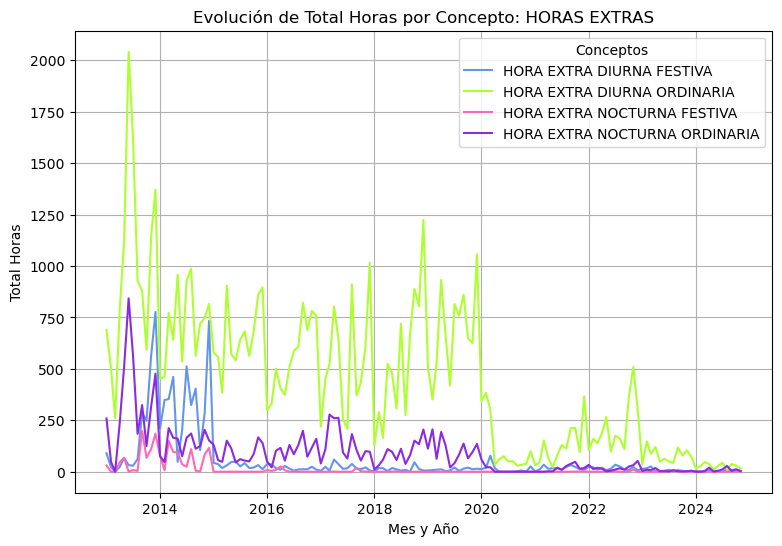

C:\Users\Juliana\AppData\Local\Temp\ipykernel_25328\3028536122.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temporal_grupo_agg = temporal_grupo.groupby(["Periodo", "Concepto"])[["Valor_Total", "Total_Horas"]].sum().reset_index()


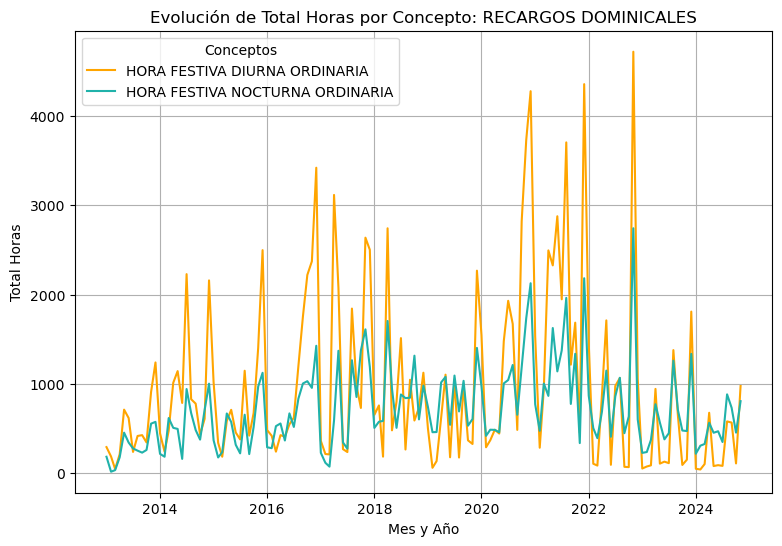

C:\Users\Juliana\AppData\Local\Temp\ipykernel_25328\3028536122.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temporal_grupo_agg = temporal_grupo.groupby(["Periodo", "Concepto"])[["Valor_Total", "Total_Horas"]].sum().reset_index()


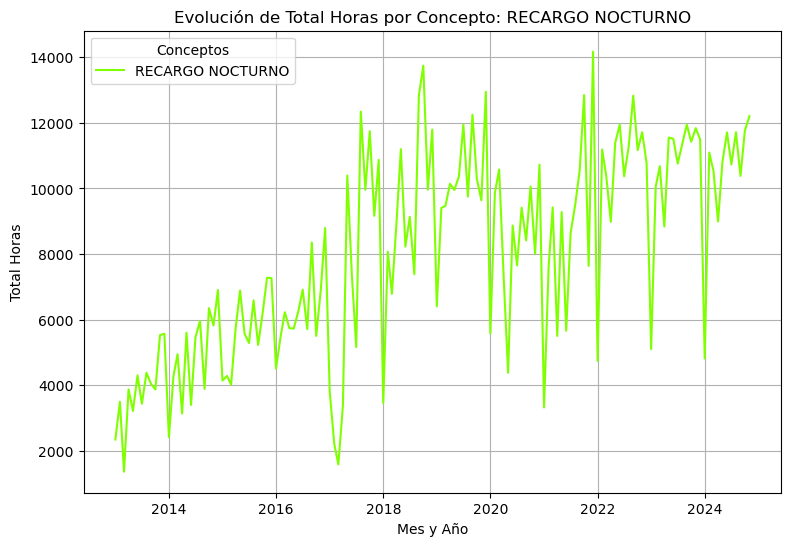

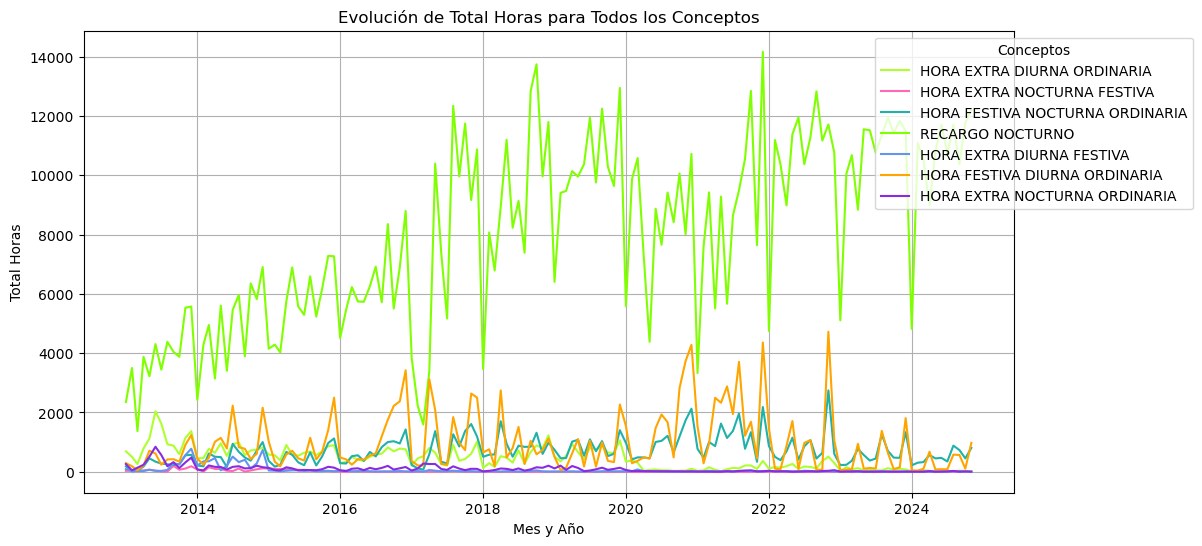

In [17]:


# Asegurar que 'Concepto' no tiene valores nulos
df2 = df2.dropna(subset=["Concepto"])

# Agregar valores mensuales por concepto
temporal = df2.groupby(["Periodo", "Concepto"])[["Valor_Total", "Total_Horas"]].sum().reset_index()

# Definir los grupos de conceptos
grupos_conceptos = {
    "HORAS EXTRAS": ['HORA EXTRA DIURNA FESTIVA', 'HORA EXTRA DIURNA ORDINARIA', 
                     'HORA EXTRA NOCTURNA FESTIVA', 'HORA EXTRA NOCTURNA ORDINARIA'],
    "RECARGOS DOMINICALES": ['HORA FESTIVA DIURNA ORDINARIA', 'HORA FESTIVA NOCTURNA ORDINARIA'],
    "RECARGO NOCTURNO": ['RECARGO NOCTURNO']
}

# Asignar colores a cada concepto
colores_conceptos = {
    'HORA EXTRA DIURNA FESTIVA': 'cornflowerblue',
    'HORA EXTRA DIURNA ORDINARIA': 'greenyellow',
    'HORA EXTRA NOCTURNA FESTIVA': 'hotpink',
    'HORA EXTRA NOCTURNA ORDINARIA': 'blueviolet',
    'HORA FESTIVA DIURNA ORDINARIA': 'orange',
    'HORA FESTIVA NOCTURNA ORDINARIA': 'lightseagreen',
    'RECARGO NOCTURNO': 'chartreuse'
}


# Crear una figura para cada grupo de conceptos
for grupo, conceptos in grupos_conceptos.items():
    # Filtrar los datos para el grupo actual
    temporal_grupo = df2[df2["Concepto"].isin(conceptos)].copy()

    # Agregar valores mensuales por concepto dentro del grupo
    temporal_grupo_agg = temporal_grupo.groupby(["Periodo", "Concepto"])[["Valor_Total", "Total_Horas"]].sum().reset_index()

    # Filtrar solo los conceptos esperados
    temporal_grupo_agg = temporal_grupo_agg[temporal_grupo_agg["Concepto"].isin(conceptos)]

    # Ordenar por fecha
    temporal_grupo_agg = temporal_grupo_agg.sort_values("Periodo")

    # Convertir Periodo a datetime64
    temporal_grupo_agg["Periodo"] = temporal_grupo_agg["Periodo"].dt.to_timestamp()

    # Crear una nueva figura para cada grupo
    plt.figure(figsize=(9, 6))
    
    # Graficar los datos de cada concepto dentro del grupo
    for concepto in conceptos:
        if concepto not in temporal_grupo_agg["Concepto"].values:
            print(f"Advertencia: {concepto} no tiene datos y no será graficado.")
            continue  

        datos = temporal_grupo_agg[temporal_grupo_agg["Concepto"] == concepto]

        # Obtener el color del concepto
        color = colores_conceptos.get(concepto, 'black')

        plt.plot(datos["Periodo"], datos["Total_Horas"], label=concepto, color=color)

    # Títulos, etiquetas y leyenda
    plt.title(f"Evolución de Total Horas por Concepto: {grupo}")
    plt.xlabel("Mes y Año")
    plt.ylabel("Total Horas")
    plt.legend(title="Conceptos")
    plt.grid(True)
    plt.show()

# **NUEVA GRÁFICA: TODOS LOS CONCEPTOS JUNTOS**
plt.figure(figsize=(12, 6))

# Obtener todos los conceptos únicos
todos_los_conceptos = df2["Concepto"].unique()

# Graficar cada concepto en la misma figura
for concepto in todos_los_conceptos:
    datos = df2[df2["Concepto"] == concepto].groupby("Periodo")[["Total_Horas"]].sum().reset_index()
    
    # Convertir Periodo a datetime64
    datos["Periodo"] = datos["Periodo"].dt.to_timestamp()

    color = colores_conceptos.get(concepto, 'black')
    
    plt.plot(datos["Periodo"], datos["Total_Horas"], label=concepto, color=color)

# Títulos, etiquetas y leyenda
plt.title("Evolución de Total Horas para Todos los Conceptos")
plt.xlabel("Mes y Año")
plt.ylabel("Total Horas")
plt.legend(title="Conceptos", loc="upper right", bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()



Procesando HORAS EXTRAS - Conceptos en datos filtrados:
['HORA EXTRA DIURNA ORDINARIA', 'HORA EXTRA NOCTURNA FESTIVA', 'HORA EXTRA DIURNA FESTIVA', 'HORA EXTRA NOCTURNA ORDINARIA']
Categories (7, object): ['HORA EXTRA DIURNA FESTIVA', 'HORA EXTRA DIURNA ORDINARIA', 'HORA EXTRA NOCTURNA FESTIVA', 'HORA EXTRA NOCTURNA ORDINARIA', 'HORA FESTIVA DIURNA ORDINARIA', 'HORA FESTIVA NOCTURNA ORDINARIA', 'RECARGO NOCTURNO']


C:\Users\Juliana\AppData\Local\Temp\ipykernel_25328\1341708735.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data_horas = df_filtrado.pivot_table(index="Centro_Costos", columns="Concepto", values="Total_Horas", aggfunc="sum").fillna(0)
C:\Users\Juliana\AppData\Local\Temp\ipykernel_25328\1341708735.py:21: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data_valor = df_filtrado.pivot_table(index="Centro_Costos", columns="Concepto", values="Valor_Total", aggfunc="sum").fillna(0)


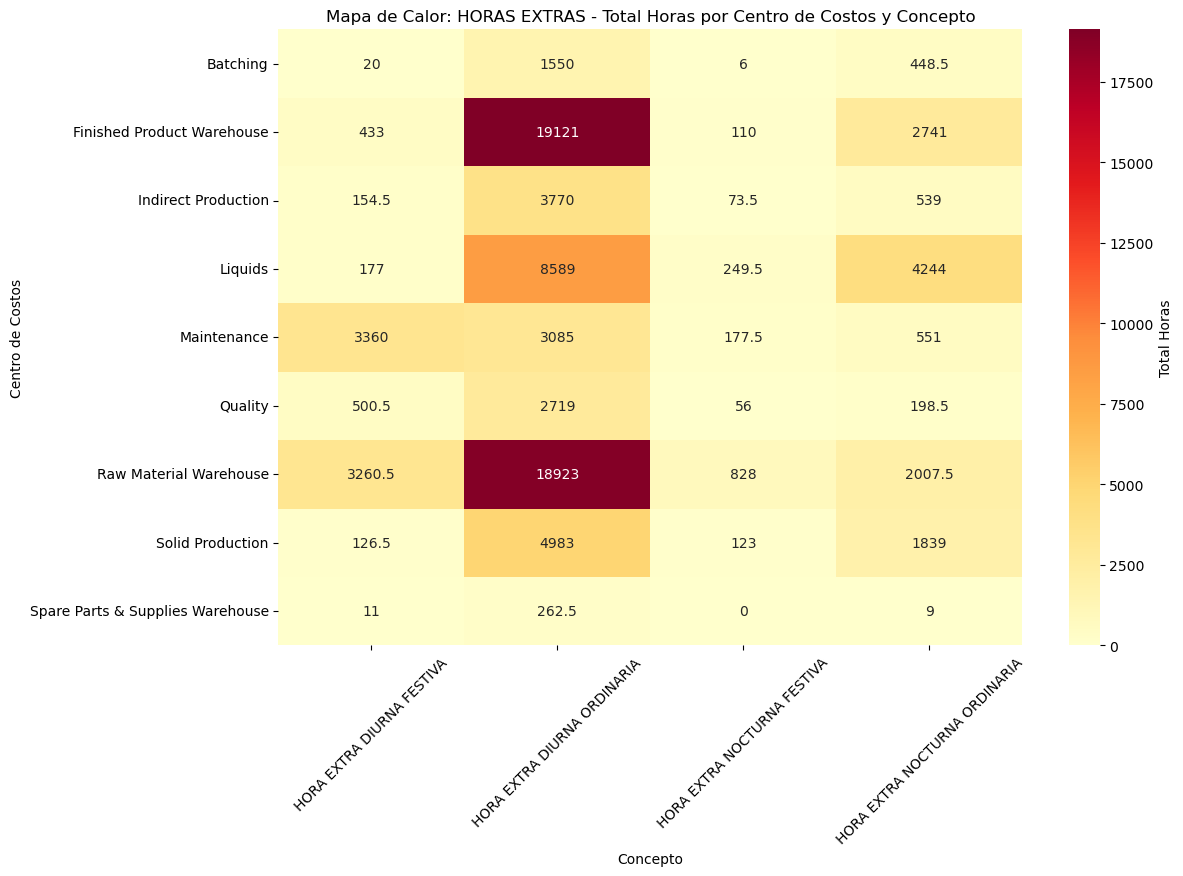


Procesando RECARGOS DOMINICALES - Conceptos en datos filtrados:
['HORA FESTIVA NOCTURNA ORDINARIA', 'HORA FESTIVA DIURNA ORDINARIA']
Categories (7, object): ['HORA EXTRA DIURNA FESTIVA', 'HORA EXTRA DIURNA ORDINARIA', 'HORA EXTRA NOCTURNA FESTIVA', 'HORA EXTRA NOCTURNA ORDINARIA', 'HORA FESTIVA DIURNA ORDINARIA', 'HORA FESTIVA NOCTURNA ORDINARIA', 'RECARGO NOCTURNO']


C:\Users\Juliana\AppData\Local\Temp\ipykernel_25328\1341708735.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data_horas = df_filtrado.pivot_table(index="Centro_Costos", columns="Concepto", values="Total_Horas", aggfunc="sum").fillna(0)
C:\Users\Juliana\AppData\Local\Temp\ipykernel_25328\1341708735.py:21: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data_valor = df_filtrado.pivot_table(index="Centro_Costos", columns="Concepto", values="Valor_Total", aggfunc="sum").fillna(0)


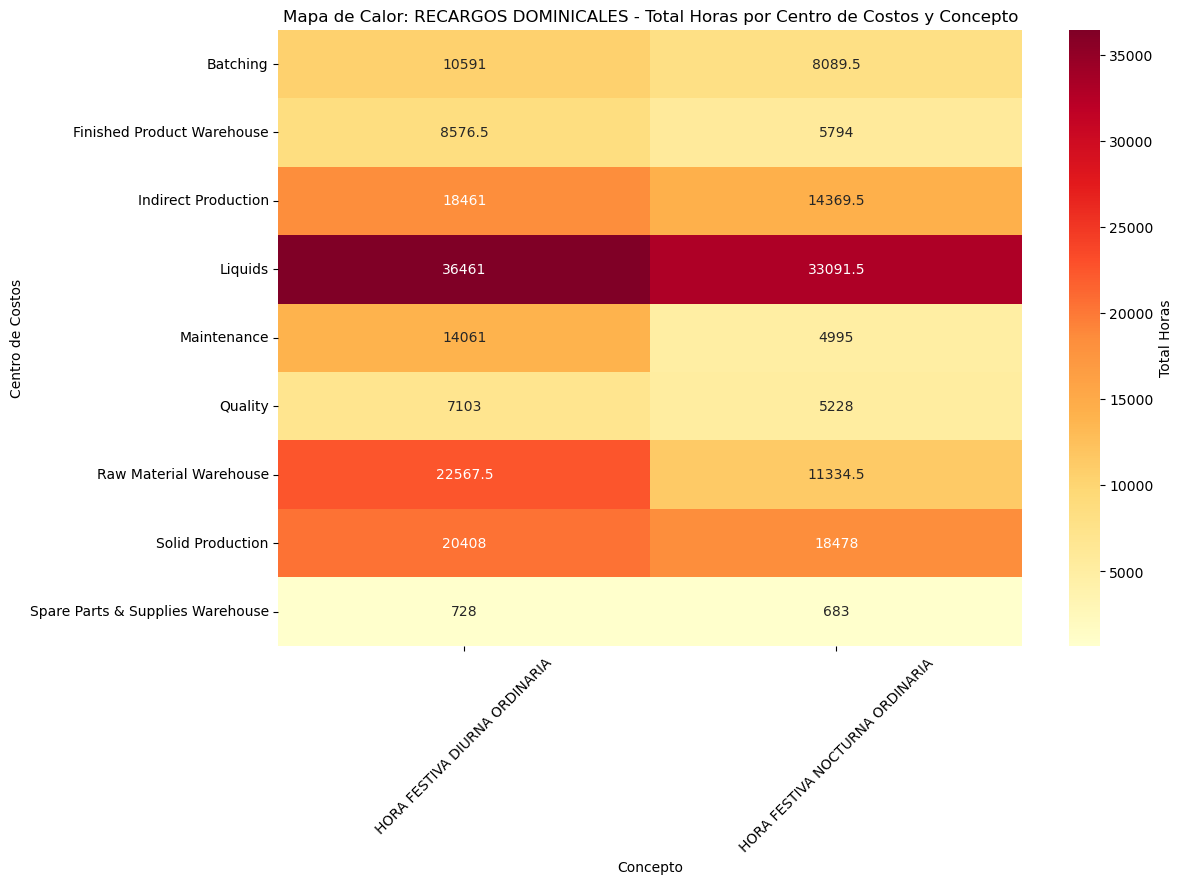


Procesando RECARGO NOCTURNO - Conceptos en datos filtrados:
['RECARGO NOCTURNO']
Categories (7, object): ['HORA EXTRA DIURNA FESTIVA', 'HORA EXTRA DIURNA ORDINARIA', 'HORA EXTRA NOCTURNA FESTIVA', 'HORA EXTRA NOCTURNA ORDINARIA', 'HORA FESTIVA DIURNA ORDINARIA', 'HORA FESTIVA NOCTURNA ORDINARIA', 'RECARGO NOCTURNO']


C:\Users\Juliana\AppData\Local\Temp\ipykernel_25328\1341708735.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data_horas = df_filtrado.pivot_table(index="Centro_Costos", columns="Concepto", values="Total_Horas", aggfunc="sum").fillna(0)
C:\Users\Juliana\AppData\Local\Temp\ipykernel_25328\1341708735.py:21: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data_valor = df_filtrado.pivot_table(index="Centro_Costos", columns="Concepto", values="Valor_Total", aggfunc="sum").fillna(0)


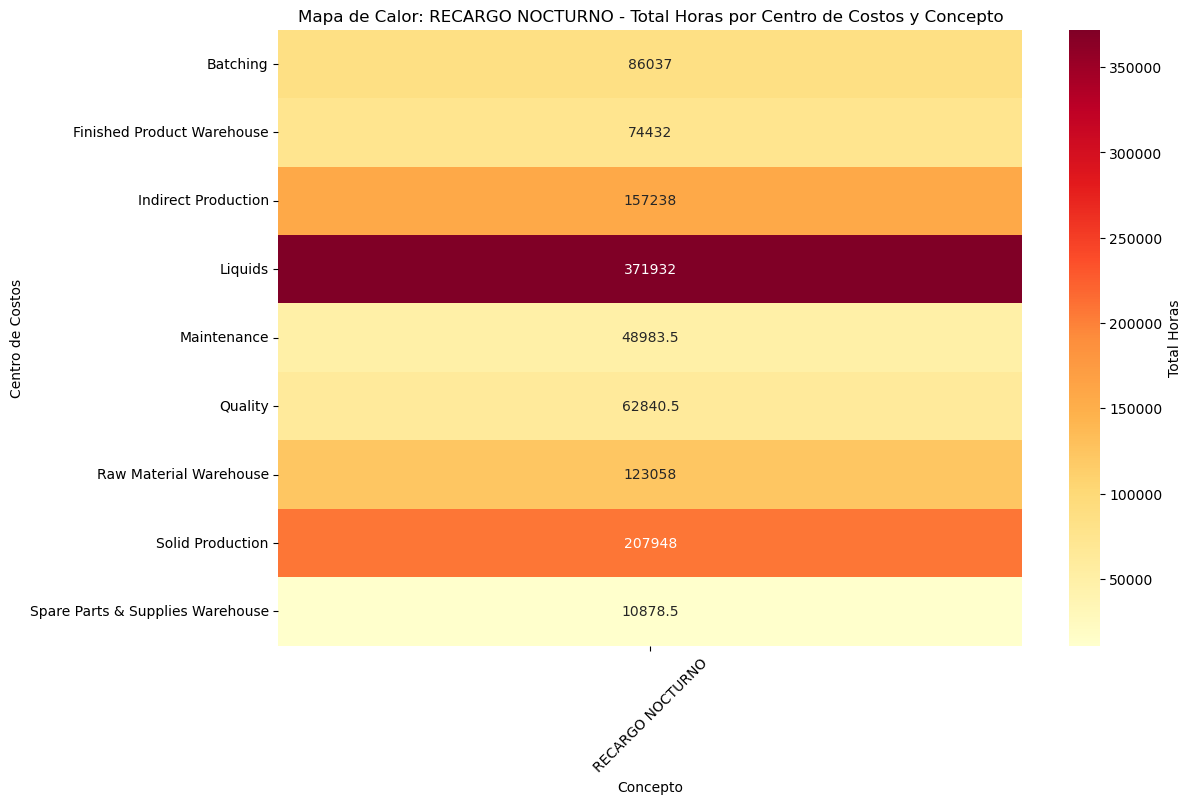

In [18]:

# Función para generar mapas de calor por grupo
def generar_heatmap_por_grupo(grupo_nombre, conceptos_del_grupo):
    # Filtrar los datos del grupo de acuerdo a los conceptos
    df_filtrado = df2[df2["Concepto"].isin(conceptos_del_grupo)].copy()

    # Verificar que el filtrado es correcto
    print(f"\nProcesando {grupo_nombre} - Conceptos en datos filtrados:")
    print(df_filtrado["Concepto"].unique())  

    if df_filtrado.empty:
        print(f"Advertencia: No hay datos suficientes para {grupo_nombre}. Se omite el mapa de calor.")
        return

    # Crear la tabla pivot solo con los conceptos del grupo (para Total Horas)
    heatmap_data_horas = df_filtrado.pivot_table(index="Centro_Costos", columns="Concepto", values="Total_Horas", aggfunc="sum").fillna(0)

    # Filtrar solo los conceptos esperados en el heatmap
    heatmap_data_horas = heatmap_data_horas[[c for c in conceptos_del_grupo if c in heatmap_data_horas.columns]]

    # Crear la tabla pivot para Valor Total
    heatmap_data_valor = df_filtrado.pivot_table(index="Centro_Costos", columns="Concepto", values="Valor_Total", aggfunc="sum").fillna(0)

    # Filtrar solo los conceptos esperados en el heatmap
    heatmap_data_valor = heatmap_data_valor[[c for c in conceptos_del_grupo if c in heatmap_data_valor.columns]]

    # Figura para Total Horas
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data_horas, annot=True, cmap="YlOrRd", fmt="g", cbar_kws={'label': 'Total Horas'})
    plt.title(f"Mapa de Calor: {grupo_nombre} - Total Horas por Centro de Costos y Concepto")
    plt.xlabel("Concepto")
    plt.ylabel("Centro de Costos")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()


# Generar mapas de calor para cada grupo
for grupo_nombre, conceptos_del_grupo in grupos_conceptos.items():
    generar_heatmap_por_grupo(grupo_nombre, conceptos_del_grupo)


In [19]:

# Diccionario para mapear los nombres de los meses a números
meses_dict = {
    "Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4, "Mayo": 5, "Junio": 6,
    "Julio": 7, "Agosto": 8, "Septiembre": 9, "Octubre": 10, "Noviembre": 11, "Diciembre": 12
}

# Convertir los nombres de los meses a números
df2["Mes_Num"] = df2["Mes"].map(meses_dict)

# Crear la columna 'Fecha' con el formato YYYY-MM-DD (siempre día 01)
df2["Fecha"] = pd.to_datetime(df2["Año"].astype(str) + "-" + df2["Mes_Num"].astype(str) + "-01")

# Eliminar la columna temporal 'Mes_Num' si no es necesaria
df2.drop(columns=["Mes_Num"], inplace=True)

# Mostrar el dataframe actualizado
print(df2)


                                             Empleado_ID Centro_Costos  \
0      124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...       Liquids   
1      124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...       Liquids   
2      124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...       Liquids   
3      124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...       Liquids   
4      481c4860f4c8894808c45980d7126b27fff161860ea69d...       Liquids   
...                                                  ...           ...   
59023  43020e1505a9891b96f5ae3a37eab10e54bab65ff21e6c...   Maintenance   
59024  43020e1505a9891b96f5ae3a37eab10e54bab65ff21e6c...   Maintenance   
59025  43020e1505a9891b96f5ae3a37eab10e54bab65ff21e6c...   Maintenance   
59026  43020e1505a9891b96f5ae3a37eab10e54bab65ff21e6c...   Maintenance   
59027  43020e1505a9891b96f5ae3a37eab10e54bab65ff21e6c...   Maintenance   

       Valor_Total  Total_Horas                         Concepto  Periodo  \
0            90131         17.0   

In [20]:
df2

,Empleado_ID,Centro_Costos,Valor_Total,Total_Horas,Concepto,Periodo,Mes,Año,Fecha
0,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,90131,17.0,HORA EXTRA DIURNA ORDINARIA,2013-04,Abril,2013,2013-04-01
1,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,63622,6.0,HORA EXTRA NOCTURNA FESTIVA,2013-04,Abril,2013,2013-04-01
2,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,17814,2.0,HORA FESTIVA NOCTURNA ORDINARIA,2013-04,Abril,2013,2013-04-01
3,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,130637,88.0,RECARGO NOCTURNO,2013-04,Abril,2013,2013-04-01
4,481c4860f4c8894808c45980d7126b27fff161860ea69d...,Liquids,67947,13.0,HORA EXTRA DIURNA ORDINARIA,2013-04,Abril,2013,2013-04-01
...,...,...,...,...,...,...,...,...,...
59023,43020e1505a9891b96f5ae3a37eab10e54bab65ff21e6c...,Maintenance,49054,2.0,HORA EXTRA DIURNA ORDINARIA,2024-09,Septiembre,2024,2024-09-01
59024,43020e1505a9891b96f5ae3a37eab10e54bab65ff21e6c...,Maintenance,549396,16.0,HORA FESTIVA DIURNA ORDINARIA,2024-11,Noviembre,2024,2024-11-01
59025,43020e1505a9891b96f5ae3a37eab10e54bab65ff21e6c...,Maintenance,370842,9.0,HORA FESTIVA NOCTURNA ORDINARIA,2024-10,Octubre,2024,2024-10-01
59026,43020e1505a9891b96f5ae3a37eab10e54bab65ff21e6c...,Maintenance,6867,1.0,RECARGO NOCTURNO,2024-11,Noviembre,2024,2024-11-01


In [21]:
# Agrupar métricas de df2 a nivel mensual
df_mensual = df2.groupby('Fecha').agg({
    'Total_Horas': 'sum',  # Sumar horas totales del mes
    'Valor_Total': 'sum',  # Sumar valor total del mes
}).reset_index()

# Crear resumen mensual por concepto y consolidar con días festivos y novedades
def crear_resumen_mensual_por_concepto(df2, df_mensual, conceptos_relevantes):
    # Filtrar datos de los conceptos relevantes
    df2_filtrado = df2[df2['Concepto'].isin(conceptos_relevantes)]
    print("Tamaño de df2 después de filtrar:", df2_filtrado.shape)

    # Agrupar por Fecha y Concepto para sumar Total_Horas
    resumen_por_concepto = (
        df2_filtrado.groupby(['Fecha', 'Concepto'])['Total_Horas']
        .sum()
        .unstack(fill_value=0)
        .reset_index()
    )

    # Retornar el DataFrame generado
    return resumen_por_concepto

# Lista de conceptos relevantes
conceptos_relevantes = [
    'HORA EXTRA DIURNA FESTIVA',
    'HORA EXTRA DIURNA ORDINARIA',
    'HORA EXTRA NOCTURNA FESTIVA',
    'HORA EXTRA NOCTURNA ORDINARIA'
]

# Crear el resumen mensual consolidado
resumen_final = crear_resumen_mensual_por_concepto(df2, df_mensual, conceptos_relevantes)

# Verificar si resumen_final no es None antes de intentar acceder a sus atributos
if resumen_final is not None:
    print("Columnas disponibles en el resumen final:")
    print(resumen_final.columns)

    print("Resumen mensual final para el análisis:")
    print(resumen_final.head())
else:
    print("Error: El resumen mensual final es None.")


Tamaño de df2 después de filtrar: (12950, 9)
Columnas disponibles en el resumen final:
Index(['Fecha', 'HORA EXTRA DIURNA FESTIVA', 'HORA EXTRA DIURNA ORDINARIA',
       'HORA EXTRA NOCTURNA FESTIVA', 'HORA EXTRA NOCTURNA ORDINARIA',
       'HORA FESTIVA DIURNA ORDINARIA', 'HORA FESTIVA NOCTURNA ORDINARIA',
       'RECARGO NOCTURNO'],
      dtype='object', name='Concepto')
Resumen mensual final para el análisis:
Concepto      Fecha  HORA EXTRA DIURNA FESTIVA  HORA EXTRA DIURNA ORDINARIA  \
0        2013-01-01                       90.0                        690.0   
1        2013-02-01                       22.0                        501.0   
2        2013-03-01                        0.0                        261.0   
3        2013-04-01                       23.0                        787.0   
4        2013-05-01                       67.0                       1119.0   

Concepto  HORA EXTRA NOCTURNA FESTIVA  HORA EXTRA NOCTURNA ORDINARIA  \
0                                30.0

C:\Users\Juliana\AppData\Local\Temp\ipykernel_25328\2242709886.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2_filtrado.groupby(['Fecha', 'Concepto'])['Total_Horas']


In [22]:
resumen_final.head()

Concepto,Fecha,HORA EXTRA DIURNA FESTIVA,HORA EXTRA DIURNA ORDINARIA,HORA EXTRA NOCTURNA FESTIVA,HORA EXTRA NOCTURNA ORDINARIA,HORA FESTIVA DIURNA ORDINARIA,HORA FESTIVA NOCTURNA ORDINARIA,RECARGO NOCTURNO
0,2013-01-01,90.0,690.0,30.0,259.0,0.0,0.0,0.0
1,2013-02-01,22.0,501.0,0.0,48.0,0.0,0.0,0.0
2,2013-03-01,0.0,261.0,0.0,0.0,0.0,0.0,0.0
3,2013-04-01,23.0,787.0,46.0,235.0,0.0,0.0,0.0
4,2013-05-01,67.0,1119.0,68.0,508.0,0.0,0.0,0.0



Analizando serie temporal para: HORA EXTRA DIURNA FESTIVA


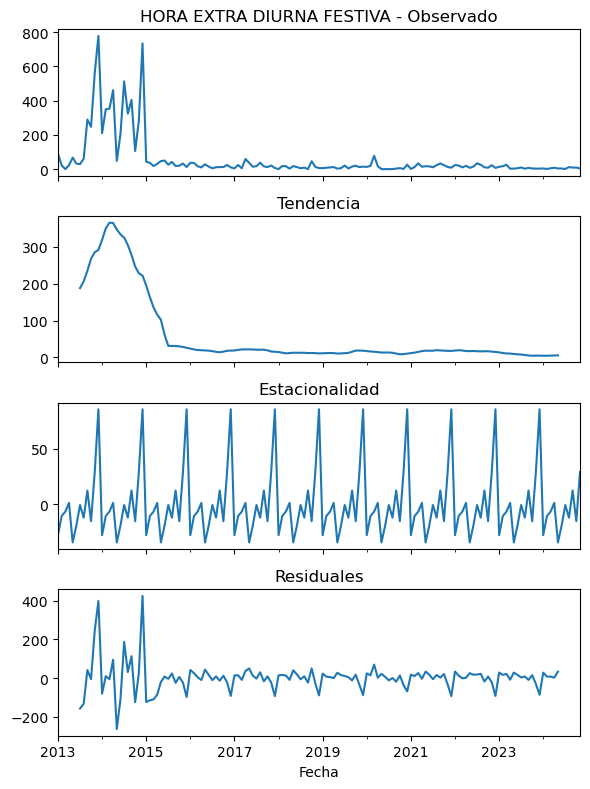


Analizando serie temporal para: HORA EXTRA DIURNA ORDINARIA


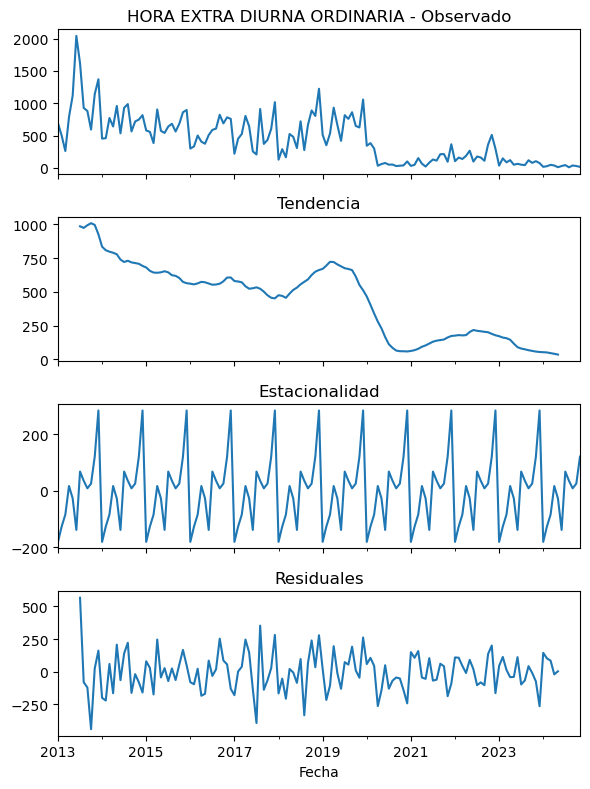


Analizando serie temporal para: HORA EXTRA NOCTURNA FESTIVA


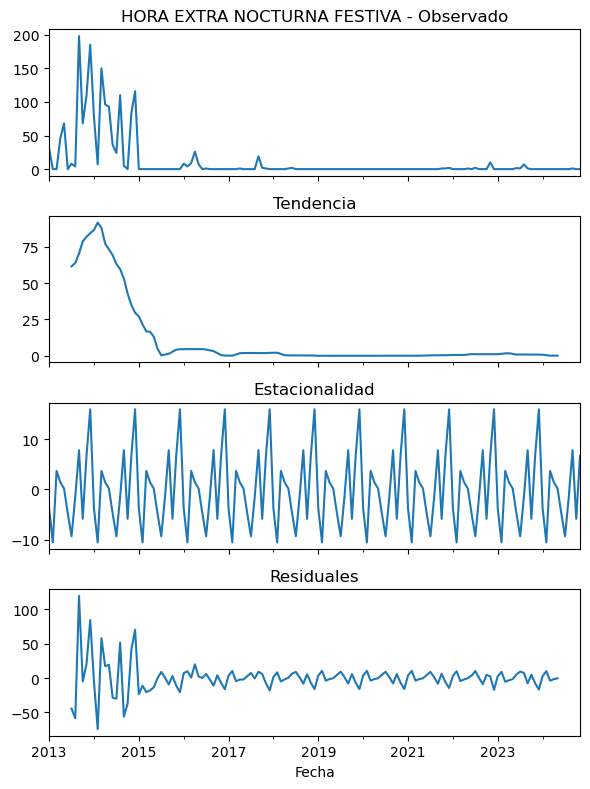


Analizando serie temporal para: HORA EXTRA NOCTURNA ORDINARIA


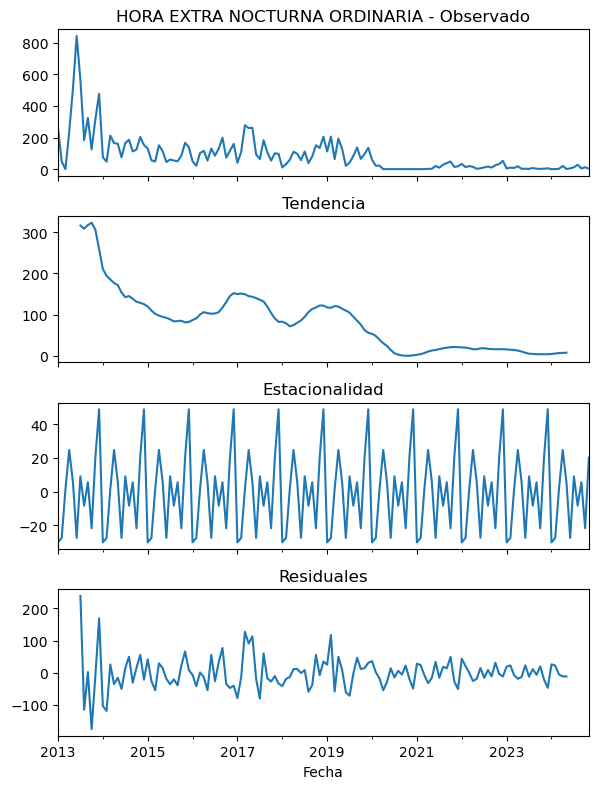

In [23]:


# Función para descomponer y graficar una serie temporal
def analizar_serie_temporal(df, concepto):
    try:
        # Filtrar datos del concepto
        data = df[['Fecha', concepto]].dropna()
        data.set_index('Fecha', inplace=True)

        # Realizar la descomposición aditiva
        descomposicion = seasonal_decompose(data[concepto], model='additive', period=12)

        # Graficar los componentes
        fig, ax = plt.subplots(4, 1, figsize=(6, 8), sharex=True)
        descomposicion.observed.plot(ax=ax[0], title=f"{concepto} - Observado")
        descomposicion.trend.plot(ax=ax[1], title="Tendencia")
        descomposicion.seasonal.plot(ax=ax[2], title="Estacionalidad")
        descomposicion.resid.plot(ax=ax[3], title="Residuales")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error al analizar la serie temporal para {concepto}: {e}")

# Lista de conceptos relevantes
conceptos_relevantes = [
    'HORA EXTRA DIURNA FESTIVA',
    'HORA EXTRA DIURNA ORDINARIA',
    'HORA EXTRA NOCTURNA FESTIVA',
    'HORA EXTRA NOCTURNA ORDINARIA'
]

# Ejecutar el análisis para cada concepto
for concepto in conceptos_relevantes:
    print(f"\nAnalizando serie temporal para: {concepto}")
    analizar_serie_temporal(resumen_final, concepto)


## Modelos Predictivos

In [24]:
df2.head()

,Empleado_ID,Centro_Costos,Valor_Total,Total_Horas,Concepto,Periodo,Mes,Año,Fecha
0,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,90131,17.0,HORA EXTRA DIURNA ORDINARIA,2013-04,Abril,2013,2013-04-01
1,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,63622,6.0,HORA EXTRA NOCTURNA FESTIVA,2013-04,Abril,2013,2013-04-01
2,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,17814,2.0,HORA FESTIVA NOCTURNA ORDINARIA,2013-04,Abril,2013,2013-04-01
3,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,130637,88.0,RECARGO NOCTURNO,2013-04,Abril,2013,2013-04-01
4,481c4860f4c8894808c45980d7126b27fff161860ea69d...,Liquids,67947,13.0,HORA EXTRA DIURNA ORDINARIA,2013-04,Abril,2013,2013-04-01


In [25]:

# Verificar que las columnas correctas existen en df2
print("Columnas en df2 antes de renombrar:", df2.columns)

if 'Fecha' in df2.columns and 'Total_Horas' in df2.columns:
    # Crear una copia con los nombres renombrados solo para Prophet
    df_prophet = df2.copy()
    df_prophet = df_prophet.rename(columns={"Fecha": "ds", "Total_Horas": "y"})
    print("Se creó df_prophet con los nombres requeridos para Prophet.")
else:
    print("ERROR: 'Fecha' o 'Total_Horas' no existen en df2.")
    print("Columnas disponibles:", df2.columns)
    exit()  # Detener ejecución si no están las columnas necesarias

# Convertir 'ds' a datetime en la copia
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Convertir 'y' a numérico en la copia
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='coerce')

# Lista de conceptos
Lista_Concepto = df_prophet["Concepto"].unique()
print(Lista_Concepto)

# DataFrame para almacenar métricas
resultados_p = []

for i in Lista_Concepto:
    print(f"\nProcesando concepto: {i}")

    # Filtrar datos por concepto en df_prophet (manteniendo df2 sin cambios)
    df_concepto = df_prophet[df_prophet["Concepto"] == i]

    # Verificar que 'ds' y 'y' siguen en df_concepto
    if "ds" not in df_concepto.columns or "y" not in df_concepto.columns:
        print(f"ERROR: Faltan columnas en {i}. Revisar filtrado.")
        continue

    # Verificar si el DataFrame está vacío después del filtrado
    if df_concepto.empty:
        print(f"Advertencia: No hay datos para {i}. Saltando...")
        continue

    # Modelo Prophet
    m = Prophet()
    m.fit(df_concepto)
    future = m.make_future_dataframe(periods=10, freq='MS')
    data = m.predict(future)
    data = data[['ds', 'yhat']]
    data["yhat"] = np.where(data["yhat"] < 0, 0, data["yhat"])
    predict_test = data.tail(9)

    # Calcular métricas
    real_test = df_concepto[["ds", "y"]].tail(9)
    mae = mean_absolute_error(real_test["y"], predict_test["yhat"])
    rmse = np.sqrt(mean_squared_error(real_test["y"], predict_test["yhat"]))
    r2 = r2_score(real_test["y"], predict_test["yhat"])
    mape = mean_absolute_percentage_error(real_test["y"], predict_test["yhat"])

    # Almacenar resultados en DataFrame
    resultados_p.append([i, mae, rmse, r2, mape])

    # Guardar CSV
    nombre_archivo = f"Prophet{i}.csv"  
    data.to_csv(nombre_archivo, sep=";", index=False)

# Convertir lista de resultados en DataFrame
resultados_p = pd.DataFrame(resultados_p, columns=["Concepto", "MAE", "RMSE", "R2", "MAPE"])

# Mostrar la tabla de resultados
print("\nResultados de predicción:")
print(resultados_p)


Columnas en df2 antes de renombrar: Index(['Empleado_ID', 'Centro_Costos', 'Valor_Total', 'Total_Horas',
       'Concepto', 'Periodo', 'Mes', 'Año', 'Fecha'],
      dtype='object')
Se creó df_prophet con los nombres requeridos para Prophet.
['HORA EXTRA DIURNA ORDINARIA', 'HORA EXTRA NOCTURNA FESTIVA', 'HORA FESTIVA NOCTURNA ORDINARIA', 'RECARGO NOCTURNO', 'HORA EXTRA DIURNA FESTIVA', 'HORA FESTIVA DIURNA ORDINARIA', 'HORA EXTRA NOCTURNA ORDINARIA']
Categories (7, object): ['HORA EXTRA DIURNA FESTIVA', 'HORA EXTRA DIURNA ORDINARIA', 'HORA EXTRA NOCTURNA FESTIVA', 'HORA EXTRA NOCTURNA ORDINARIA', 'HORA FESTIVA DIURNA ORDINARIA', 'HORA FESTIVA NOCTURNA ORDINARIA', 'RECARGO NOCTURNO']

Procesando concepto: HORA EXTRA DIURNA ORDINARIA


19:37:19 - cmdstanpy - INFO - Chain [1] start processing
19:37:20 - cmdstanpy - INFO - Chain [1] done processing
19:37:20 - cmdstanpy - INFO - Chain [1] start processing
19:37:20 - cmdstanpy - INFO - Chain [1] done processing



Procesando concepto: HORA EXTRA NOCTURNA FESTIVA

Procesando concepto: HORA FESTIVA NOCTURNA ORDINARIA


19:37:21 - cmdstanpy - INFO - Chain [1] start processing
19:37:25 - cmdstanpy - INFO - Chain [1] done processing



Procesando concepto: RECARGO NOCTURNO


19:37:26 - cmdstanpy - INFO - Chain [1] start processing
19:37:29 - cmdstanpy - INFO - Chain [1] done processing
19:37:29 - cmdstanpy - INFO - Chain [1] start processing



Procesando concepto: HORA EXTRA DIURNA FESTIVA


19:37:29 - cmdstanpy - INFO - Chain [1] done processing



Procesando concepto: HORA FESTIVA DIURNA ORDINARIA


19:37:30 - cmdstanpy - INFO - Chain [1] start processing
19:37:32 - cmdstanpy - INFO - Chain [1] done processing
19:37:33 - cmdstanpy - INFO - Chain [1] start processing



Procesando concepto: HORA EXTRA NOCTURNA ORDINARIA


19:37:33 - cmdstanpy - INFO - Chain [1] done processing



Resultados de predicción:
                          Concepto        MAE       RMSE         R2      MAPE
0      HORA EXTRA DIURNA ORDINARIA   1.113706   1.403311  -0.417883  0.805374
1      HORA EXTRA NOCTURNA FESTIVA   0.721038   0.787592 -24.122200  0.776593
2  HORA FESTIVA NOCTURNA ORDINARIA   2.353290   3.556195  -0.620836  0.438649
3                 RECARGO NOCTURNO  42.731282  45.893814  -0.152316  8.105298
4        HORA EXTRA DIURNA FESTIVA   0.824132   0.923811  -2.456381  0.588127
5    HORA FESTIVA DIURNA ORDINARIA   6.529695   7.299659  -3.611204  0.659532
6    HORA EXTRA NOCTURNA ORDINARIA   0.755474   0.987241 -14.789235  1.142724


In [26]:
df2.head()

,Empleado_ID,Centro_Costos,Valor_Total,Total_Horas,Concepto,Periodo,Mes,Año,Fecha
0,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,90131,17.0,HORA EXTRA DIURNA ORDINARIA,2013-04,Abril,2013,2013-04-01
1,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,63622,6.0,HORA EXTRA NOCTURNA FESTIVA,2013-04,Abril,2013,2013-04-01
2,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,17814,2.0,HORA FESTIVA NOCTURNA ORDINARIA,2013-04,Abril,2013,2013-04-01
3,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,130637,88.0,RECARGO NOCTURNO,2013-04,Abril,2013,2013-04-01
4,481c4860f4c8894808c45980d7126b27fff161860ea69d...,Liquids,67947,13.0,HORA EXTRA DIURNA ORDINARIA,2013-04,Abril,2013,2013-04-01


In [29]:

# Crear copia de df2 sin modificarlo
df_es = df2.copy()

df_es['Fecha'] = pd.to_datetime(df_es['Fecha'], errors='coerce')
df_es["Concepto"] = df_es["Concepto"].str.strip()
df_es['Total_Horas'] = pd.to_numeric(df_es['Total_Horas'], errors='coerce')

# Verificar que las columnas correctas existen en df2
print("Columnas en df2 antes de renombrar:", df2.columns)

# Renombrar columnas en la copia
df_es = df_es.rename(columns={"Fecha": "ds", "Total_Horas": "y"})

# Lista de conceptos
Lista_Concepto = df_es["Concepto"].unique()
print("Conceptos encontrados:", Lista_Concepto)


# Loop para entrenar modelo Exponential Smoothing

resultados_ES = []

for i in Lista_Concepto:
    print(f"\nProcesando concepto: {i}")

    # Filtrar datos por concepto
    df_concepto = df_es[df_es["Concepto"] == i].copy()

    #Convertir fechas a formato datetime
    df_concepto["ds"] = pd.to_datetime(df_concepto["ds"], format='%Y-%m-%d')

    # Asegurar que 'y' sea numérico y eliminar valores NaN
    df_concepto["y"] = pd.to_numeric(df_concepto["y"], errors='coerce')
    df_concepto = df_concepto.dropna(subset=["y"])
    
    # Filtrar rango de fechas
    df_concepto = df_concepto[(df_concepto["ds"] >= "2021-01-01") & (df_concepto["ds"] <= "2024-07-01")]
    df_concepto = df_concepto[["ds", "y"]]

    # Verificar si el DataFrame está vacío después del filtrado
    if df_concepto.empty:
        print(f"Advertencia: No hay datos para {i}. Saltando...")
        continue

    # Convertir índice de tiempo
    df_concepto = df_concepto.set_index("ds")

    # Ajustar el modelo Exponential Smoothing
    try:
        modelo_es = ExponentialSmoothing(df_concepto["y"], seasonal_periods=12,
                                         trend="multiplicative", seasonal="multiplicative",
                                         use_boxcox=True, initialization_method="estimated").fit()
    except:
        modelo_es = ExponentialSmoothing(df_concepto["y"], seasonal_periods=12,
                                         trend="add", seasonal="add",
                                         use_boxcox=False, initialization_method="estimated").fit()

    # Predicción del Futuro (6 meses)
    future = modelo_es.forecast(6).reset_index()
    future.columns = ["ds", "yhat"]

    
    #Predicción en los datos actuales
    prediction = modelo_es.fittedvalues.reset_index()
    prediction.columns = ["ds", "yhat"]

    
    # Evaluación del Modelo
    real_test = df_concepto["y"].tail(9)  # Últimos 9 valores reales
    predict_test = prediction["yhat"].tail(9)  # Últimos 9 valores predichos

# Eliminar NaN
    real_test = real_test.dropna()
    predict_test = predict_test.dropna()

# Asegurar que ambas listas tengan la misma longitud
    min_length = min(len(real_test), len(predict_test))
    real_test = real_test.iloc[-min_length:]
    predict_test = predict_test.iloc[-min_length:]

# Verificar NaN antes de calcular métricas
    if real_test.isna().sum() > 0 or predict_test.isna().sum() > 0:
        print("Advertencia: Hay valores NaN en real_test o predict_test.")
        print("real_test con NaN:", real_test[real_test.isna()])
        print("predict_test con NaN:", predict_test[predict_test.isna()])
        continue

# Calcular métricas
    mae = mean_absolute_error(real_test, predict_test)
    rmse = np.sqrt(mean_squared_error(real_test, predict_test))
    r2 = r2_score(real_test, predict_test)
    mape = mean_absolute_percentage_error(real_test, predict_test)

    print(f"Resultados para {i}: MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}, MAPE={mape:.4f}")

    # Almacenar resultados en DataFrame
    resultados_ES.append([i, mae, rmse, r2, mape])

    # Guardar CSV
    nombre_archivo = f"{i}.csv"
    future.to_csv(nombre_archivo, sep=";", index=False)


# Convertir lista de resultados en DataFrame
resultados_ES = pd.DataFrame(resultados_ES, columns=["Concepto", "MAE", "RMSE", "R2", "MAPE"])

# Guardar la tabla de métricas
# ==========================
resultados_ES.to_csv("Resultados_ExponentialSmoothing.csv", sep=";", index=False)

# ==========================
# Mostrar la tabla de resultados
# ==========================
print("\nResultados de predicción:")
print(resultados_ES)


Columnas en df2 antes de renombrar: Index(['Empleado_ID', 'Centro_Costos', 'Valor_Total', 'Total_Horas',
       'Concepto', 'Periodo', 'Mes', 'Año', 'Fecha'],
      dtype='object')
Conceptos encontrados: ['HORA EXTRA DIURNA ORDINARIA' 'HORA EXTRA NOCTURNA FESTIVA'
 'HORA FESTIVA NOCTURNA ORDINARIA' 'RECARGO NOCTURNO'
 'HORA EXTRA DIURNA FESTIVA' 'HORA FESTIVA DIURNA ORDINARIA'
 'HORA EXTRA NOCTURNA ORDINARIA']

Procesando concepto: HORA EXTRA DIURNA ORDINARIA


C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is

Resultados para HORA EXTRA DIURNA ORDINARIA: MAE=0.5657, RMSE=0.7896, R²=-0.0202, MAPE=0.5760

Procesando concepto: HORA EXTRA NOCTURNA FESTIVA


C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473

Resultados para HORA EXTRA NOCTURNA FESTIVA: MAE=0.0102, RMSE=0.0212, R²=0.9817, MAPE=0.0159

Procesando concepto: HORA FESTIVA NOCTURNA ORDINARIA


C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473

Resultados para HORA FESTIVA NOCTURNA ORDINARIA: MAE=0.4885, RMSE=0.6613, R²=-0.1070, MAPE=0.1959

Procesando concepto: RECARGO NOCTURNO


C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Resultados para RECARGO NOCTURNO: MAE=18.7101, RMSE=21.3279, R²=-0.5513, MAPE=0.3192

Procesando concepto: HORA EXTRA DIURNA FESTIVA


C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is

Resultados para HORA EXTRA DIURNA FESTIVA: MAE=0.4427, RMSE=0.4565, R²=-0.2057, MAPE=0.3908

Procesando concepto: HORA FESTIVA DIURNA ORDINARIA


C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473

Resultados para HORA FESTIVA DIURNA ORDINARIA: MAE=4.0758, RMSE=10.6440, R²=-0.0922, MAPE=0.1615

Procesando concepto: HORA EXTRA NOCTURNA ORDINARIA
Resultados para HORA EXTRA NOCTURNA ORDINARIA: MAE=60.1498, RMSE=100.3209, R²=0.0000, MAPE=60.1498

Resultados de predicción:
                          Concepto        MAE        RMSE        R2       MAPE
0      HORA EXTRA DIURNA ORDINARIA   0.565671    0.789607 -0.020238   0.576023
1      HORA EXTRA NOCTURNA FESTIVA   0.010176    0.021233  0.981740   0.015938
2  HORA FESTIVA NOCTURNA ORDINARIA   0.488518    0.661322 -0.107035   0.195858
3                 RECARGO NOCTURNO  18.710096   21.327910 -0.551281   0.319195
4        HORA EXTRA DIURNA FESTIVA   0.442743    0.456494 -0.205666   0.390816
5    HORA FESTIVA DIURNA ORDINARIA   4.075802   10.644038 -0.092233   0.161546
6    HORA EXTRA NOCTURNA ORDINARIA  60.149839  100.320902  0.000000  60.149839


C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [30]:

# Copia del dataset original
df_rnn = df2.copy()

# Lista de conceptos únicos
Lista_Concepto = df_rnn["Concepto"].unique()

# DataFrame para almacenar métricas
resultados_rnn = []

for concepto in Lista_Concepto:
    print(f"\nProcesando RNN para: {concepto}")
    
    # Filtrar datos por concepto
    df_concepto = df_rnn[df_rnn["Concepto"] == concepto][["Fecha", "Total_Horas"]].copy()
    df_concepto["Fecha"] = pd.to_datetime(df_concepto["Fecha"], errors='coerce')
    df_concepto = df_concepto.sort_values("Fecha").reset_index(drop=True)
    
    # Normalizar los datos
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df_concepto[["Total_Horas"]])
    
    # Crear secuencias para la RNN
    X, y = [], []
    sequence_length = 3  # Ventana de observación de 3 períodos
    
    for i in range(len(df_scaled) - sequence_length):
        X.append(df_scaled[i:i+sequence_length])
        y.append(df_scaled[i+sequence_length])
    
    X, y = np.array(X), np.array(y)
    
    # Verificar que hay suficientes datos para entrenar
    if len(X) == 0 or len(y) == 0:
        print(f"Advertencia: No hay suficientes datos para {concepto}. Saltando...")
        continue
    
    # División de datos en entrenamiento y prueba
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    try:
        # Definir el modelo RNN con LSTM
        model = Sequential([
            LSTM(50, activation='relu', return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
            LSTM(50, activation='relu'),
            Dense(1)  # Predicción de Total_Horas
        ])
        
        model.compile(optimizer='adam', loss='mse')
        
        # Entrenar modelo
        model.fit(X_train, y_train, epochs=100, verbose=0)
        
        # Hacer predicciones
        predictions_rnn = model.predict(X_test)
        predictions_rnn = scaler.inverse_transform(predictions_rnn)  # Desnormalizar
        y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))
        
        # Evaluación del modelo
        mae = mean_absolute_error(y_test_real, predictions_rnn)
        rmse = np.sqrt(mean_squared_error(y_test_real, predictions_rnn))
        r2 = r2_score(y_test_real, predictions_rnn)
        mape = mean_absolute_percentage_error(y_test_real, predictions_rnn) * 100  # Como porcentaje
        
        # Almacenar resultados en DataFrame
        resultados_rnn.append([concepto, mae, rmse, r2, mape])
        
        # Guardar predicciones en CSV
        pred_df = pd.DataFrame({
            "Fecha": df_concepto["Fecha"][train_size + sequence_length:],
            "Total_Horas_Real": y_test_real.flatten(),
            "Total_Horas_Pred": predictions_rnn.flatten()
        })
        pred_df.to_csv(f"RNN_{concepto}.csv", index=False)
        
    except Exception as e:
        print(f"Error al procesar {concepto}: {str(e)}")

# Convertir lista de resultados en DataFrame
df_resultados_rnn = pd.DataFrame(resultados_rnn, columns=["Concepto", "MAE", "RMSE", "R2", "MAPE"])

# Mostrar tabla final de métricas
print("\nResultados de predicción con RNN:")
print(df_resultados_rnn)

df_resultados_rnn.to_csv("RNN_Resultados.csv", index=False)



Procesando RNN para: HORA EXTRA DIURNA ORDINARIA


C:\Users\Juliana\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Procesando RNN para: HORA EXTRA NOCTURNA FESTIVA


C:\Users\Juliana\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 494ms/step

Procesando RNN para: HORA FESTIVA NOCTURNA ORDINARIA


C:\Users\Juliana\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Procesando RNN para: RECARGO NOCTURNO


C:\Users\Juliana\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Procesando RNN para: HORA EXTRA DIURNA FESTIVA


C:\Users\Juliana\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step

Procesando RNN para: HORA FESTIVA DIURNA ORDINARIA


C:\Users\Juliana\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Procesando RNN para: HORA EXTRA NOCTURNA ORDINARIA


C:\Users\Juliana\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

Resultados de predicción con RNN:
                          Concepto        MAE       RMSE        R2        MAPE
0      HORA EXTRA DIURNA ORDINARIA   6.079991   8.010990  0.023324  362.296018
1      HORA EXTRA NOCTURNA FESTIVA   1.821037   1.896291 -4.378140  184.907837
2  HORA FESTIVA NOCTURNA ORDINARIA   2.278260   2.974275  0.121909   92.146056
3                 RECARGO NOCTURNO  25.823299  30.396316 -0.000870  195.134162
4        HORA EXTRA DIURNA FESTIVA   1.319642   1.641679 -0.208210   97.201451
5    HORA FESTIVA DIURNA ORDINARIA   3.710407   5.422849  0.398459   38.295700
6    HORA EXTRA NOCTURNA ORDINARIA   1.970263   2.588858 -0.142706  165.103148


In [31]:

# Fusionar los DataFrames en un solo DataFrame comparativo
df_comparacion = resultados_p.merge(resultados_ES, on="Concepto", suffixes=("_P", "_ES"))
df_comparacion = df_comparacion.merge(df_resultados_rnn, on="Concepto", suffixes=("", "_RNN"))

# Renombrar las columnas de RNN para que no queden sin sufijo
df_comparacion = df_comparacion.rename(columns={
    "MAE": "MAE_RNN", "RMSE": "RMSE_RNN", "R2": "R2_RNN", "MAPE": "MAPE_RNN"
})


In [32]:
df_comparacion 

,Concepto,MAE_P,RMSE_P,R2_P,MAPE_P,MAE_ES,RMSE_ES,R2_ES,MAPE_ES,MAE_RNN,RMSE_RNN,R2_RNN,MAPE_RNN
0,HORA EXTRA DIURNA ORDINARIA,1.113706,1.403311,-0.417883,0.805374,0.565671,0.789607,-0.020238,0.576023,6.079991,8.010990,0.023324,362.296018
1,HORA EXTRA NOCTURNA FESTIVA,0.721038,0.787592,-24.122200,0.776593,0.010176,0.021233,0.981740,0.015938,1.821037,1.896291,-4.378140,184.907837
2,HORA FESTIVA NOCTURNA ORDINARIA,2.353290,3.556195,-0.620836,0.438649,0.488518,0.661322,-0.107035,0.195858,2.278260,2.974275,0.121909,92.146056
3,RECARGO NOCTURNO,42.731282,45.893814,-0.152316,8.105298,18.710096,21.327910,-0.551281,0.319195,25.823299,30.396316,-0.000870,195.134162
4,HORA EXTRA DIURNA FESTIVA,0.824132,0.923811,-2.456381,0.588127,0.442743,0.456494,-0.205666,0.390816,1.319642,1.641679,-0.208210,97.201451
5,HORA FESTIVA DIURNA ORDINARIA,6.529695,7.299659,-3.611204,0.659532,4.075802,10.644038,-0.092233,0.161546,3.710407,5.422849,0.398459,38.295700
6,HORA EXTRA NOCTURNA ORDINARIA,0.755474,0.987241,-14.789235,1.142724,60.149839,100.320902,0.000000,60.149839,1.970263,2.588858,-0.142706,165.103148


In [33]:
resultados_p

,Concepto,MAE,RMSE,R2,MAPE
0,HORA EXTRA DIURNA ORDINARIA,1.113706,1.403311,-0.417883,0.805374
1,HORA EXTRA NOCTURNA FESTIVA,0.721038,0.787592,-24.122200,0.776593
2,HORA FESTIVA NOCTURNA ORDINARIA,2.353290,3.556195,-0.620836,0.438649
3,RECARGO NOCTURNO,42.731282,45.893814,-0.152316,8.105298
4,HORA EXTRA DIURNA FESTIVA,0.824132,0.923811,-2.456381,0.588127
5,HORA FESTIVA DIURNA ORDINARIA,6.529695,7.299659,-3.611204,0.659532
6,HORA EXTRA NOCTURNA ORDINARIA,0.755474,0.987241,-14.789235,1.142724


In [34]:
resultados_ES

,Concepto,MAE,RMSE,R2,MAPE
0,HORA EXTRA DIURNA ORDINARIA,0.565671,0.789607,-0.020238,0.576023
1,HORA EXTRA NOCTURNA FESTIVA,0.010176,0.021233,0.981740,0.015938
2,HORA FESTIVA NOCTURNA ORDINARIA,0.488518,0.661322,-0.107035,0.195858
3,RECARGO NOCTURNO,18.710096,21.327910,-0.551281,0.319195
4,HORA EXTRA DIURNA FESTIVA,0.442743,0.456494,-0.205666,0.390816
5,HORA FESTIVA DIURNA ORDINARIA,4.075802,10.644038,-0.092233,0.161546
6,HORA EXTRA NOCTURNA ORDINARIA,60.149839,100.320902,0.000000,60.149839


In [35]:
df_resultados_rnn

,Concepto,MAE,RMSE,R2,MAPE
0,HORA EXTRA DIURNA ORDINARIA,6.079991,8.010990,0.023324,362.296018
1,HORA EXTRA NOCTURNA FESTIVA,1.821037,1.896291,-4.378140,184.907837
2,HORA FESTIVA NOCTURNA ORDINARIA,2.278260,2.974275,0.121909,92.146056
3,RECARGO NOCTURNO,25.823299,30.396316,-0.000870,195.134162
4,HORA EXTRA DIURNA FESTIVA,1.319642,1.641679,-0.208210,97.201451
5,HORA FESTIVA DIURNA ORDINARIA,3.710407,5.422849,0.398459,38.295700
6,HORA EXTRA NOCTURNA ORDINARIA,1.970263,2.588858,-0.142706,165.103148


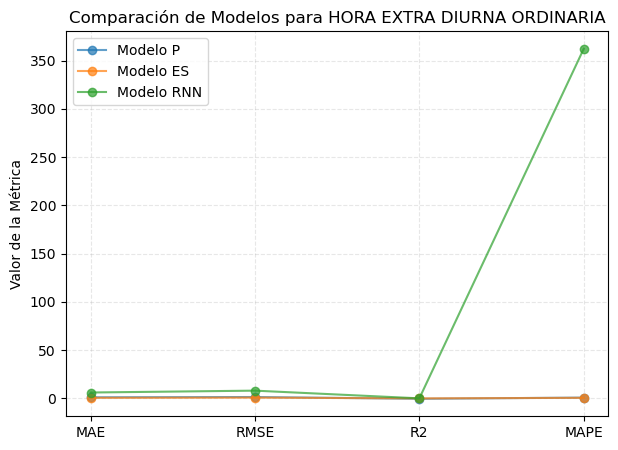

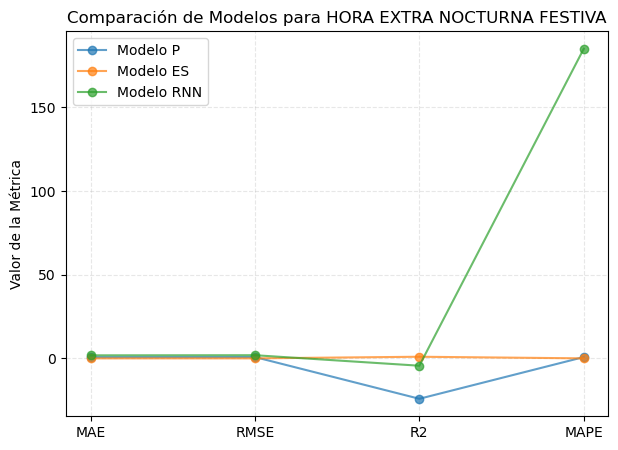

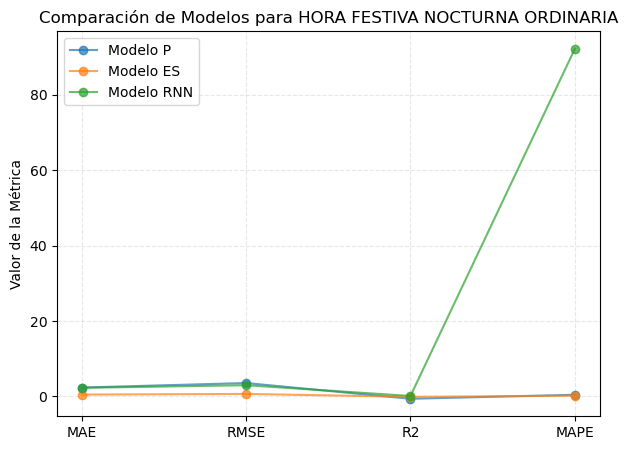

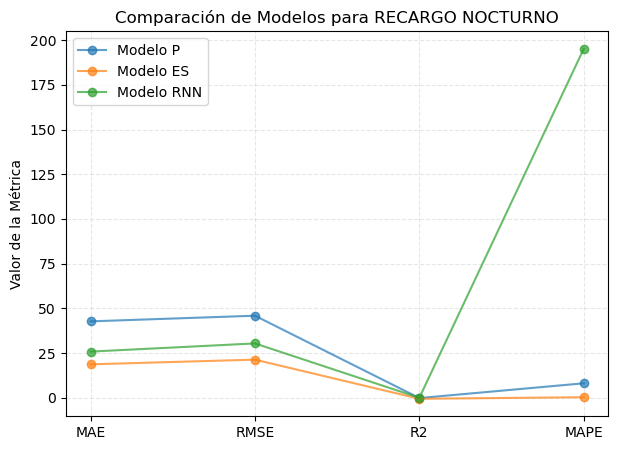

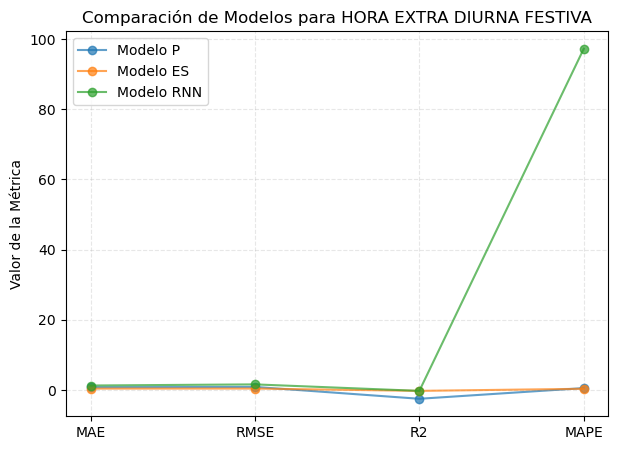

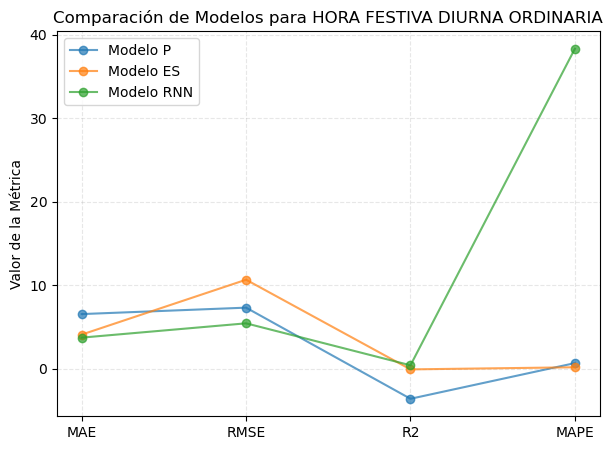

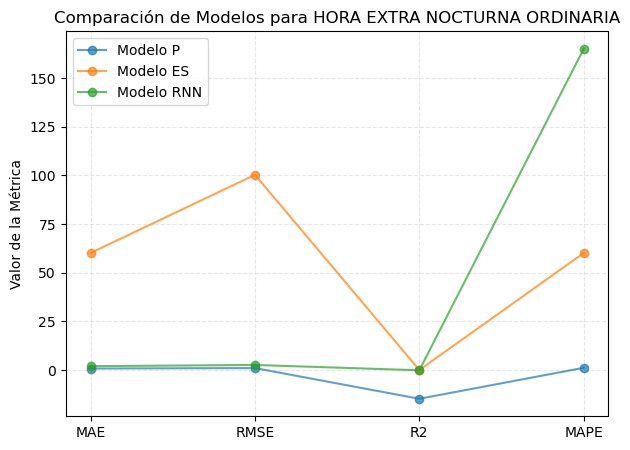

In [36]:

# Lista de conceptos únicos
conceptos = df_comparacion["Concepto"].unique()

# Crear gráficos individuales por concepto
for concepto in conceptos:
    df_temp = df_comparacion[df_comparacion["Concepto"] == concepto]
    
    plt.figure(figsize=(7, 5))
    
    # Métricas a graficar
    metricas = ["MAE", "RMSE", "R2", "MAPE"]
    x = np.arange(len(metricas))  # Índices de métricas en el eje X
    
    for modelo in ["P", "ES", "RNN"]:
        valores = [df_temp[f"{metrica}_{modelo}"].values[0] for metrica in metricas]
        
        # Graficar con líneas más delgadas y semitransparentes
        plt.plot(x, valores, marker='o', linestyle='-', linewidth=1.5, alpha=0.7, label=f"Modelo {modelo}")
    
    plt.xticks(x, metricas)  # Usar etiquetas de métricas en el eje X
    plt.title(f"Comparación de Modelos para {concepto}")
    plt.ylabel("Valor de la Métrica")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)  # Líneas de la cuadrícula más sutiles
    plt.show()


In [37]:


# Copia del dataset original
df_rnn = df2.copy()

# Lista de conceptos únicos
Lista_Concepto = df_rnn["Concepto"].unique()

# **Paso 1: Detección y Eliminación de Valores Atípicos**
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_rnn["Outlier"] = iso_forest.fit_predict(df_rnn[["Total_Horas"]])
df_sin_outliers = df_rnn[df_rnn["Outlier"] == 1]

# **Paso 2: Aplicar Suavizado Exponencial**
df_sin_outliers["Total_Horas_Suavizado"] = df_sin_outliers["Total_Horas"].ewm(span=5, adjust=False).mean()

# **Paso 3: Entrenar Modelos para Cada Concepto**
resultados = []

for concepto in Lista_Concepto:
    df_concepto = df_sin_outliers[df_sin_outliers["Concepto"] == concepto].copy()
    
    if df_concepto.empty or len(df_concepto) < 10:
        print(f"Advertencia: No hay suficientes datos para {concepto}. Saltando...")
        continue
    
    X_ridge = df_concepto[["Total_Horas_Suavizado"]].values
    y_ridge = df_concepto["Total_Horas"].values

    # **Regresión Ridge**
    modelo_ridge = Ridge(alpha=1.0)
    modelo_ridge.fit(X_ridge, y_ridge)
    df_concepto["Pred_Ridge"] = modelo_ridge.predict(X_ridge)

    # **Random Forest**
    modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
    modelo_rf.fit(X_ridge, y_ridge)
    df_concepto["Pred_RF"] = modelo_rf.predict(X_ridge)

    # **XGBoost**
    modelo_xgb = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, random_state=42)
    modelo_xgb.fit(X_ridge, y_ridge)
    df_concepto["Pred_XGB"] = modelo_xgb.predict(X_ridge)

    # **Calcular métricas por concepto**
    for modelo, nombre in zip(["Pred_Ridge", "Pred_RF", "Pred_XGB"], ["Ridge", "Random Forest", "XGBoost"]):
        mae = mean_absolute_error(y_ridge, df_concepto[modelo])
        rmse = np.sqrt(mean_squared_error(y_ridge, df_concepto[modelo]))
        r2 = r2_score(y_ridge, df_concepto[modelo])
        mape = mean_absolute_percentage_error(y_ridge, df_concepto[modelo])

        resultados.append([concepto, nombre, mae, rmse, r2, mape])

# Convertir resultados a DataFrame
df_resultados_concepto = pd.DataFrame(resultados, columns=["Concepto", "Modelo", "MAE", "RMSE", "R2", "MAPE"])

# Guardar y mostrar resultados
df_resultados_concepto.to_csv("Evaluacion_Modelos_Por_Concepto.csv", index=False)

# Imprimir las métricas
print("\nEvaluación de Modelos Combinados por Concepto:")
print(df_resultados_concepto)


C:\Users\Juliana\AppData\Local\Temp\ipykernel_25328\3267643210.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sin_outliers["Total_Horas_Suavizado"] = df_sin_outliers["Total_Horas"].ewm(span=5, adjust=False).mean()



Evaluación de Modelos Combinados por Concepto:
                           Concepto         Modelo        MAE       RMSE  \
0       HORA EXTRA DIURNA ORDINARIA          Ridge   6.253363   8.677361   
1       HORA EXTRA DIURNA ORDINARIA  Random Forest   2.607245   3.844411   
2       HORA EXTRA DIURNA ORDINARIA        XGBoost   6.046346   8.440686   
3       HORA EXTRA NOCTURNA FESTIVA          Ridge   2.493093   3.262511   
4       HORA EXTRA NOCTURNA FESTIVA  Random Forest   0.995157   1.355981   
5       HORA EXTRA NOCTURNA FESTIVA        XGBoost   1.340957   1.920807   
6   HORA FESTIVA NOCTURNA ORDINARIA          Ridge   4.016835   5.308934   
7   HORA FESTIVA NOCTURNA ORDINARIA  Random Forest   1.695936   2.368093   
8   HORA FESTIVA NOCTURNA ORDINARIA        XGBoost   3.913015   5.197677   
9                  RECARGO NOCTURNO          Ridge  18.459681  22.666573   
10                 RECARGO NOCTURNO  Random Forest   6.318102   8.943141   
11                 RECARGO NOCTURNO     

In [39]:
df_comparacion

,Concepto,MAE_P,RMSE_P,R2_P,MAPE_P,MAE_ES,RMSE_ES,R2_ES,MAPE_ES,MAE_RNN,RMSE_RNN,R2_RNN,MAPE_RNN
0,HORA EXTRA DIURNA ORDINARIA,1.113706,1.403311,-0.417883,0.805374,0.565671,0.789607,-0.020238,0.576023,6.079991,8.010990,0.023324,362.296018
1,HORA EXTRA NOCTURNA FESTIVA,0.721038,0.787592,-24.122200,0.776593,0.010176,0.021233,0.981740,0.015938,1.821037,1.896291,-4.378140,184.907837
2,HORA FESTIVA NOCTURNA ORDINARIA,2.353290,3.556195,-0.620836,0.438649,0.488518,0.661322,-0.107035,0.195858,2.278260,2.974275,0.121909,92.146056
3,RECARGO NOCTURNO,42.731282,45.893814,-0.152316,8.105298,18.710096,21.327910,-0.551281,0.319195,25.823299,30.396316,-0.000870,195.134162
4,HORA EXTRA DIURNA FESTIVA,0.824132,0.923811,-2.456381,0.588127,0.442743,0.456494,-0.205666,0.390816,1.319642,1.641679,-0.208210,97.201451
5,HORA FESTIVA DIURNA ORDINARIA,6.529695,7.299659,-3.611204,0.659532,4.075802,10.644038,-0.092233,0.161546,3.710407,5.422849,0.398459,38.295700
6,HORA EXTRA NOCTURNA ORDINARIA,0.755474,0.987241,-14.789235,1.142724,60.149839,100.320902,0.000000,60.149839,1.970263,2.588858,-0.142706,165.103148


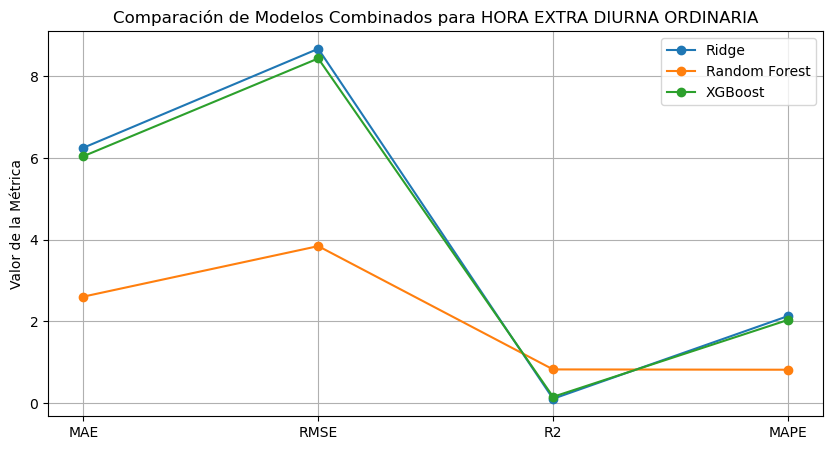

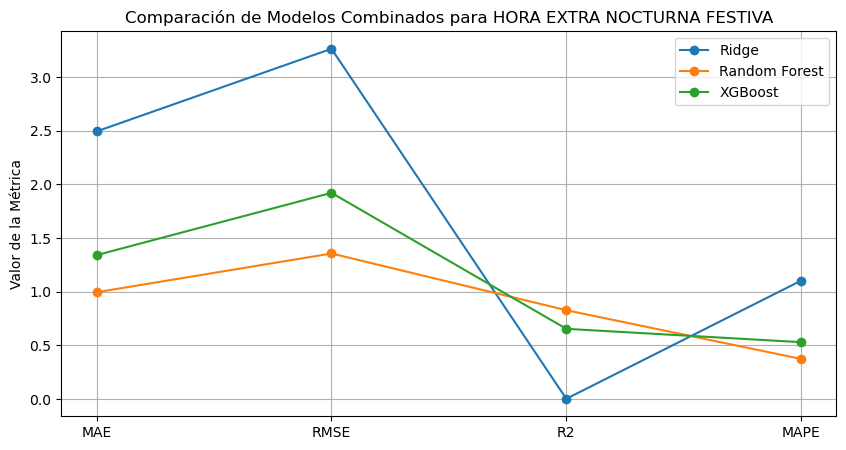

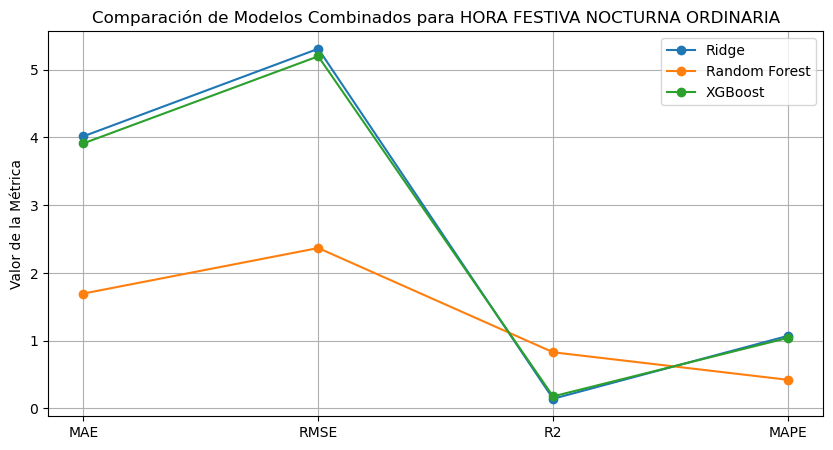

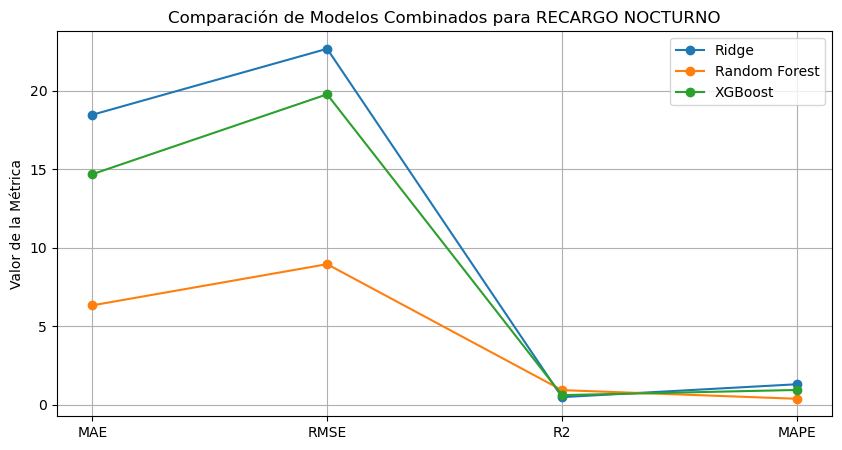

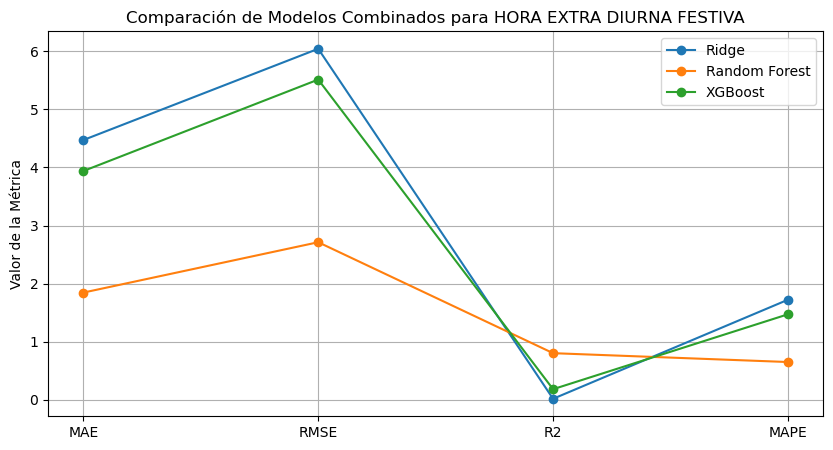

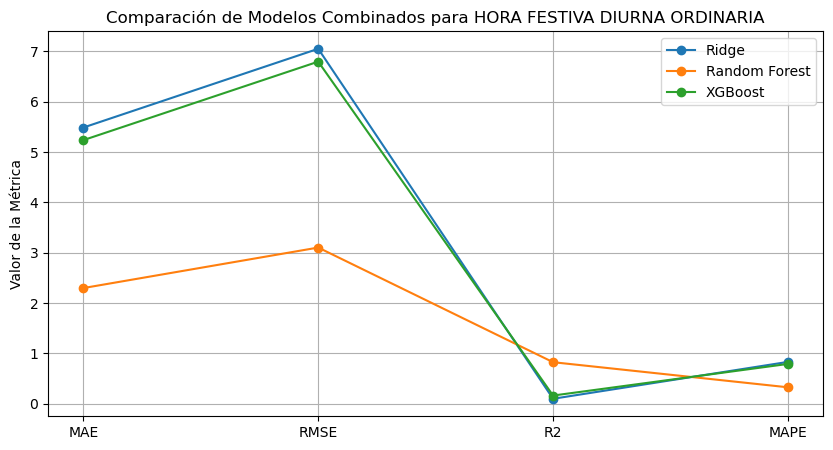

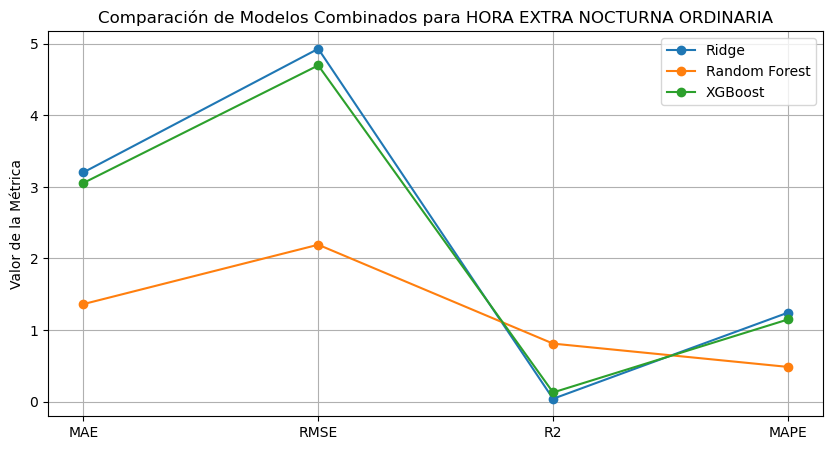

In [41]:
import matplotlib.pyplot as plt

# Lista de conceptos únicos
conceptos_unicos = df_resultados_concepto["Concepto"].unique()

# Modelos combinados que queremos graficar
modelos_combinados = ["Ridge", "Random Forest", "XGBoost"]

# Crear gráficos individuales por concepto
for concepto in conceptos_unicos:
    df_temp = df_resultados_concepto[df_resultados_concepto["Concepto"] == concepto]

    plt.figure(figsize=(10, 5))

    # Graficar cada modelo
    for modelo in modelos_combinados:
        df_modelo = df_temp[df_temp["Modelo"] == modelo]
        
        if df_modelo.empty:
            continue  # Saltar si no hay datos para el modelo

        valores = [df_modelo["MAE"].values[0], 
                   df_modelo["RMSE"].values[0], 
                   df_modelo["R2"].values[0], 
                   df_modelo["MAPE"].values[0]]
        
        plt.plot(["MAE", "RMSE", "R2", "MAPE"], valores, marker='o', label=modelo)

    # Personalización de la gráfica
    plt.title(f"Comparación de Modelos Combinados para {concepto}")
    plt.ylabel("Valor de la Métrica")
    plt.legend()
    plt.grid(True)

    # Mostrar gráfico
    plt.show()
